# Репликация простой модели Linear Expenditure System
Данная работа является репликацией учебного примера из видео "Estimating the Linear Expenditure System in R "

Сссылка:https://www.youtube.com/watch?v=F68uDaaPjQA

Реплицировано на основе: https://github.com/EconJohn/Linear-Expenditure-System 

Данные по канадским домохозяйствам: https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=3610022501

## Загрузка библиотек

In [57]:
#Нужна библиотека для чтения CSV
#Библиотека для работы с датафреймами
import pandas as pd
#Для простой регрессии
import statsmodels.formula.api as smf
#Для графиков
import matplotlib.pyplot as plt
#Нам нужен упорядоченный словарь для системы уравнений
from collections import OrderedDict
#Понадобится для добавления константы
import statsmodels.api as sm
#Для оценки систем одновременных уравнений
from linearmodels.system import SUR

## Работа с данными

In [58]:
#Загрузка Датафрейма
#ОБРАТИТЕ ВНИМАНИЕ, ЧТО В СЕПАРИРУЮЩИЙ ЗНАК = 	, Т.Е. ТАБУЛЯЦИЯ
#Подготовка данных
Canada = pd.read_csv(r'C:\Users\79618\Desktop\LES\Canada.txt', sep="	")
Canada=Canada.rename(columns={'Unnamed: 0': "Time"})
Canada=Canada.rename(columns={'Housing water electricity gas and other fuels': "Housing"})
Canada=Canada.rename(columns={'Water supply and sanitation services': "Water"})
Canada=Canada.rename(columns={'Paid rental fees for housing': "Paid_rental_fees"})
Canada=Canada.rename(columns={'Imputed rental fees for housing': "Imputed_rental_fees"})
Canada=Canada.rename(columns={'Materials for the maintenance and repair of the dwelling': "Materials_maintenance"})
Canada=Canada.rename(columns={'Services for the maintenance and repair of the dwelling': "Services_maintenance"})
Canada=Canada.rename(columns={'Other fuels': "Other_fuels"})
Canada

,Time,Housing,Paid_rental_fees,Imputed_rental_fees,Materials_maintenance,Services_maintenance,Water,Electricity,Gas,Other_fuels
0,1981,40096.0,9027.0,22794.0,644.0,35.0,666.0,3004.0,1552.0,2374.0
1,1982,45755.0,10290.0,25818.0,669.0,41.0,760.0,3452.0,2014.0,2711.0
2,1983,50456.0,11489.0,28798.0,708.0,42.0,843.0,3894.0,2244.0,2438.0
3,1984,54417.0,12367.0,31197.0,742.0,47.0,906.0,4400.0,2372.0,2386.0
4,1985,58557.0,13145.0,33667.0,802.0,51.0,966.0,4796.0,2572.0,2558.0
5,1986,62593.0,14114.0,36686.0,905.0,57.0,1059.0,5157.0,2476.0,2139.0
6,1987,66982.0,15245.0,39963.0,967.0,64.0,1150.0,5373.0,2330.0,1890.0
7,1988,73593.0,16582.0,43898.0,1009.0,72.0,1286.0,6166.0,2552.0,2028.0
8,1989,81163.0,18377.0,48658.0,1066.0,88.0,1457.0,6789.0,2560.0,2168.0
9,1990,87712.0,19989.0,52709.0,1076.0,98.0,1618.0,7308.0,2580.0,2334.0


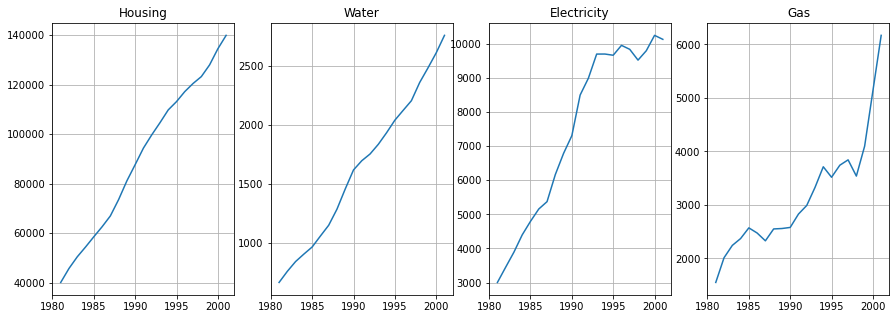

In [60]:
fig,axs=plt.subplots(1,4,figsize = (15, 5))
for i in range(4):
    axs[i].plot("Time",Canada.columns[[1,6,7,8,9][i]],data=Canada)
    axs[i].set(title=Canada.columns[[1,6,7,8,9][i]])
    axs[i].grid()

## Статистическая оценка

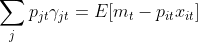

In [61]:
#Step2: Estimate of essential expenditure by obtaining fitted values over time
#Оценка абсолютно необходимых расходов (ниже которых нельзя потреблять)
reg=smf.ols(formula='Housing~Time',data=Canada)
results=reg.fit()

In [101]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Housing   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3081.
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           1.73e-22
Time:                        22:50:02   Log-Likelihood:                -193.31
No. Observations:                  21   AIC:                             390.6
Df Residuals:                      19   BIC:                             392.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.989e+06   1.82e+05    -55.004      0.0

In [95]:
#Добавим эти fitted values в датафреймы
acon=results.fittedvalues
Canada['detrended']=Canada['Housing']-acon
Canada['Acon']=acon
Canada.head()

,const,Time,Housing,Paid_rental_fees,Imputed_rental_fees,Materials_maintenance,Services_maintenance,Water,Electricity,Gas,Other_fuels,detrended,Acon
0,1.0,1981,40096.0,9027.0,22794.0,644.0,35.0,666.0,3004.0,1552.0,2374.0,-74.658009,40170.658009
1,1.0,1982,45755.0,10290.0,25818.0,669.0,41.0,760.0,3452.0,2014.0,2711.0,521.560173,45233.439827
2,1.0,1983,50456.0,11489.0,28798.0,708.0,42.0,843.0,3894.0,2244.0,2438.0,159.778355,50296.221645
3,1.0,1984,54417.0,12367.0,31197.0,742.0,47.0,906.0,4400.0,2372.0,2386.0,-942.003463,55359.003463
4,1.0,1985,58557.0,13145.0,33667.0,802.0,51.0,966.0,4796.0,2572.0,2558.0,-1864.785281,60421.785281


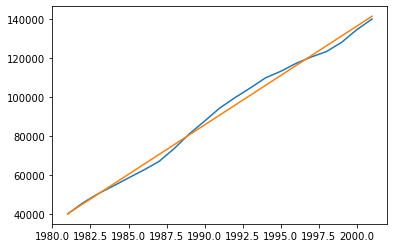

In [64]:
plt.plot("Time","Housing",data=Canada)
plt.plot(Canada["Time"],acon)

Далее проведелем оценку методом **Seemingly Unrelated Regressions (SUR)**

In [100]:
#Добавим константу
Canada=sm.add_constant(Canada)

**СОВПАЛО С РЕШЕНИЕМ В R!**

In [98]:
equations = OrderedDict()
equations['gasoline'] = {'dependent': Canada.Gas,
                         'exog': Canada[[ 'const','detrended']]}
equations['electricity'] = {'dependent': Canada.Electricity,
                         'exog': Canada[[ 'const','detrended']]}
equations['water'] = {'dependent': Canada.Water,
                         'exog': Canada[[ 'const','detrended']]}
mod = SUR(equations)

In [99]:
print(mod.fit(cov_type='unadjusted'))

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.0512
No. Equations.:                     3   McElroy's R-squared:                 0.3049
No. Observations:                  21   Judge's (OLS) R-squared:             0.0512
Date:                Fri, Aug 12 2022   Berndt's R-squared:                  0.5682
Time:                        22:49:30   Dhrymes's R-squared:                 0.0512
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
                 Equation: gasoline, Dependent Variable: Gas                  
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          3150.6     229.18     13.747     0.0000      2701.4      3599.8
detrended   

**Интерпритация результатов:**

3150 (млн.$)- subsistence consumption ГАЗА в Канаде (Значима с почти нулевой p-value)

-0.0353 - снижение потребление газа по мере роста ????? (инфириорное блего, мало значима)

## Расширения модели

### Модель без цен

https://showdata.gks.ru/olap2/descr/report/273820 - Индексы потребительских цен на товары и услуги в группировке Классификатора индивидуального потребления по целям (КИПЦ)

https://rosstat.gov.ru/compendium/document/13271

Определяем *encoding*, чтобы предотвратить ошибку:
    
**UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position ...**

In [307]:
with open(r'C:\Users\79618\Downloads\Russia.csv') as f:
    print(f)

<_io.TextIOWrapper name='C:\\Users\\79618\\Downloads\\Russia.csv' mode='r' encoding='cp1251'>


In [242]:
Russia = pd.read_csv(r'C:\Users\79618\Downloads\Russia.csv', sep="," ,encoding='cp1251',header=1)

In [308]:
with open(r'C:\Users\79618\Desktop\(3 курс) Курсовая работа\Data\ИНДЕКСЫ ЦЕН (ПО КВАРТАЛАМ).csv') as f:
    print(f)

<_io.TextIOWrapper name='C:\\Users\\79618\\Desktop\\(3 курс) Курсовая работа\\Data\\ИНДЕКСЫ ЦЕН (ПО КВАРТАЛАМ).csv' mode='r' encoding='cp1251'>


In [309]:
Price_index = pd.read_csv(r'C:\Users\79618\Desktop\(3 курс) Курсовая работа\Data\ИНДЕКСЫ ЦЕН (ПО КВАРТАЛАМ).csv', sep="," ,encoding='cp1251',header=2)

In [310]:
Price_index

,Unnamed: 0,Unnamed: 1,10000 ПРОДУКТЫ ПИТАНИЯ И БЕЗАЛКОГОЛЬНЫЕ НАПИТКИ,100000 ОБРАЗОВАНИЕ,1000000 ВСЕ ТОВАРЫ И УСЛУГИ,"1001 Маргарин, кг",101000 Дошкольное и начальное образование (У),102000 Основное общее и среднее (полное) общее образование (У),103000 Среднее профессиональное образование (У),104000 Высшее профессиональное образование (У),...,"9941 Обучение в негосударственных образовательных организациях высшего профессионального образования, семестр","9942 Обучение в государственных и муниципальных образовательных организациях высшего профессионального образования, семестр","9991 Повторное получение гербового документа в органах ЗАГС, документ","9992 Ксерокопирование документа, лист","9993 Пользование общественным туалетом, посещение",w2:p_kipc:150081 Приправы и пряности,w2:p_kipc:160000 ИПЦ без учета взносов на капитальный ремонт,"w2:p_kipc:2005 Соль йодированная пищевая, кг","w2:p_kipc:201 Колбаса вареная, кг",w2:p_kipc:91413 Другие носители для записи звука и изображения
0,11521100300010200003 Индексы потребительских ц...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 кв. 2011 г.,NaN,"106,43","100,58","104,13","105,06",NaN,"100,67","100,5","100,3",...,"100,53","100,2",100,"102,02","102,62",NaN,NaN,NaN,NaN,NaN
2,2 кв. 2011 г.,NaN,"101,1","100,26","101,5","102,99",NaN,"100,26","100,27","100,15",...,"100,42","100,04",100,"101,41","102,83",NaN,NaN,NaN,NaN,NaN
3,3 кв. 2011 г.,NaN,"97,2","102,68","100,12","101,7",NaN,"102,65","103,23","102,68",...,"101,43","103,17",100,"101,7","102,82",NaN,NaN,NaN,NaN,NaN
4,4 кв. 2011 г.,NaN,"99,85","103,5","100,8","100,99",NaN,"104,95","103,31","103,12",...,"101,39","103,8",100,"101,73","101,4",NaN,NaN,NaN,NaN,NaN
5,1 кв. 2012 г.,NaN,"102,05","100,35","101,38","100,59",NaN,"100,54","100,39","100,21",...,"100,28","100,18",100,"100,81","101,63",NaN,NaN,NaN,NaN,NaN
6,2 кв. 2012 г.,NaN,"101,88","100,33","101,47","100,52",NaN,"100,32","100,15","100,27",...,"100,25","100,27",100,"101,33","101,04",NaN,NaN,NaN,NaN,NaN
7,3 кв. 2012 г.,NaN,"101,79","105,51","102,26","100,46",NaN,"101,64","102,52","107,89",...,"101,86","110,29",100,"101,56","102,22",NaN,NaN,NaN,NaN,NaN
8,4 кв. 2012 г.,NaN,"100,74","105,85","101,27","101,86",NaN,"104,42","103,97","107,11",...,"102,02","108,97",100,"102,33","102,66",NaN,NaN,NaN,NaN,NaN
9,1 кв. 2013 г.,NaN,"102,49","100,34","101,94","101,51",NaN,"100,49","100,35","100,2",...,"100,44","100,12",100,"101,75","102,44",NaN,NaN,NaN,NaN,NaN


In [280]:
Russia.columns[1]

'Unnamed: 1'

In [144]:
Russia=Russia.rename(columns={'Unnamed: 0': "Good"})
Russia

,Good,Unnamed: 1,январь 2010 г.,февраль 2010 г.,март 2010 г.,апрель 2010 г.,май 2010 г.,июнь 2010 г.,июль 2010 г.,август 2010 г.,...,сентябрь 2021 г.,октябрь 2021 г.,ноябрь 2021 г.,декабрь 2021 г.,январь 2022 г.,февраль 2022 г.,март 2022 г.,апрель 2022 г.,май 2022 г.,июнь 2022 г.
0,К предыдущему месяцу,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Российская Федерация,643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ПРОДУКТЫ ПИТАНИЯ И БЕЗАЛКОГОЛЬНЫЕ НАПИТКИ,10000,"101,5",NaN,"101,04","100,19","100,67","100,57","100,3","101,03",...,"101,17","102,57","101,47","101,59","101,59","101,74","107,24","102,97","100,51","98,63"
3,ОБРАЗОВАНИЕ,100000,"100,47",NaN,"100,11","100,05","100,05","100,02","100,25","101,06",...,"104,33","100,18","100,18","100,03","100,19","100,04","100,17","100,12","100,07","100,08"
4,ВСЕ ТОВАРЫ И УСЛУГИ,1000000,"101,64",NaN,"100,63","100,29","100,5","100,39","100,36","100,55",...,"100,6","101,11","100,96","100,82","100,99","101,17","107,61","101,56","100,12","99,65"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,Приправы и пряности,w2:p_kipc:150081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"100,64","100,57","100,86","100,81","100,92","101,25","106,74","106,12","103,18","101,43"
1343,ИПЦ без учета взносов на капитальный ремонт,w2:p_kipc:160000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"100,61","101,11","100,96","100,83","100,93","101,17","107,67","101,57","100,12","99,64"
1344,"Соль йодированная пищевая, кг",w2:p_kipc:2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1345,"Колбаса вареная, кг",w2:p_kipc:201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"100,87","101,27","101,36","101,45","100,4","100,61","102,86","103,75","100,94","100,11"


In [153]:
big_categories=[]
for i in range(len(Russia.Good)):
    if Russia.Good[i].isupper():
        print(i,Russia.Good[i])
        big_categories.append(i)

2 ПРОДУКТЫ ПИТАНИЯ И БЕЗАЛКОГОЛЬНЫЕ НАПИТКИ
3 ОБРАЗОВАНИЕ
4 ВСЕ ТОВАРЫ И УСЛУГИ
15 ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ
190 ДРУГИЕ ТОВАРЫ И УСЛУГИ
418 АЛКОГОЛЬНЫЕ НАПИТКИ, ТАБАЧНЫЕ ИЗДЕЛИЯ
485 ОДЕЖДА И ОБУВЬ
575 ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ЭЛЕКТРОЭНЕРГИЯ, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА
733 ПРЕДМЕТЫ ДОМАШНЕГО ОБИХОДА, БЫТОВАЯ ТЕХНИКА И ПОВСЕДНЕВНЫЙ УХОД ЗА ДОМОМ
851 ЗДРАВООХРАНЕНИЕ
923 ТРАНСПОРТ
1087 СВЯЗЬ
1129 ОРГАНИЗАЦИЯ ОТДЫХА И КУЛЬТУРНЫЕ МЕРОПРИЯТИЯ


In [158]:
Russia.loc[big_categories]

,Good,Unnamed: 1,январь 2010 г.,февраль 2010 г.,март 2010 г.,апрель 2010 г.,май 2010 г.,июнь 2010 г.,июль 2010 г.,август 2010 г.,...,сентябрь 2021 г.,октябрь 2021 г.,ноябрь 2021 г.,декабрь 2021 г.,январь 2022 г.,февраль 2022 г.,март 2022 г.,апрель 2022 г.,май 2022 г.,июнь 2022 г.
2,ПРОДУКТЫ ПИТАНИЯ И БЕЗАЛКОГОЛЬНЫЕ НАПИТКИ,10000,"101,5",NaN,"101,04","100,19","100,67","100,57","100,3","101,03",...,"101,17","102,57","101,47","101,59","101,59","101,74","107,24","102,97","100,51","98,63"
3,ОБРАЗОВАНИЕ,100000,"100,47",NaN,"100,11","100,05","100,05","100,02","100,25","101,06",...,"104,33","100,18","100,18","100,03","100,19","100,04","100,17","100,12","100,07","100,08"
4,ВСЕ ТОВАРЫ И УСЛУГИ,1000000,"101,64",NaN,"100,63","100,29","100,5","100,39","100,36","100,55",...,"100,6","101,11","100,96","100,82","100,99","101,17","107,61","101,56","100,12","99,65"
15,"ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ",110000,"100,59",NaN,"100,76","100,52","100,68","100,33","100,39","100,59",...,"100,56","100,66","100,14","100,54","100,58","100,51","104,15","102,73","101,03","100,64"
190,ДРУГИЕ ТОВАРЫ И УСЛУГИ,120000,"100,98",NaN,"100,58","100,55","100,38","100,34","100,32","100,38",...,"100,61","100,51","100,65","100,57","101,14","101,25","112,63","103,02","99,7","99,47"
418,"АЛКОГОЛЬНЫЕ НАПИТКИ, ТАБАЧНЫЕ ИЗДЕЛИЯ",20000,"101,36",NaN,"101,16","100,89","100,83","100,49","100,44","100,55",...,"100,17","100,36","100,13","100,32","100,71","100,67","103,07","101,62","100,95","100,37"
485,ОДЕЖДА И ОБУВЬ,30000,"100,37",NaN,"100,57","100,46","100,35","100,25","100,2","100,41",...,"100,63","100,62","100,34","100,28","99,99","100,23","105,1","101,13","100,26","99,9"
575,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ЭЛЕКТРОЭНЕРГИЯ, ГАЗ И Д...",40000,"108,13",NaN,"100,1","100,2","100,08","100,14","100,18","100,23",...,"100,02","100,13","100,23","100,09","100,58","100,81","101,65","100,18","100,09","99,75"
733,"ПРЕДМЕТЫ ДОМАШНЕГО ОБИХОДА, БЫТОВАЯ ТЕХНИКА И ...",50000,"100,41",NaN,"100,31","100,24","100,15","100,12","100,16","100,25",...,"100,89","100,72","100,71","100,83","100,72","101,19","114,7","100,25","100,23","99,69"
851,ЗДРАВООХРАНЕНИЕ,60000,"100,48",NaN,"100,22","99,77","99,89","100,31","100,09","100,27",...,"100,27","100,55","100,31","100,27","100,51","100,72","107,16","100,5","100,04","100,01"


In [151]:
Russia.Good[1].isupper()

False

https://rosstat.gov.ru/compendium/document/13271 - 	Уровень и состав располагаемых ресурсов и расходов на потребление домашних хозяйств

In [360]:
Households = pd.read_excel(r'C:\Users\79618\Desktop\(3 курс) Курсовая работа\Data\ДХ.xlsx',header=0)

In [362]:
Households.head()

,Потребление,2007Q1,2007Q2,2007Q3,2007Q4,2008Q1,2008Q2,2008Q3,2008Q4,2009Q1,...,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1
0,ГОД,2007.0,2007.0,2007.0,2007.0,2008.0,2008.0,2008.0,2008.0,2009.0,...,2019.000,2020.000,2020.000,2020.000,2020.00,2021.000,2021.000,2021.000,2021.000,2022.000
1,КВАРТАЛ,1.0,2.0,3.0,4.0,1.0,2.0,3.0,4.0,1.0,...,4.000,1.000,2.000,3.000,4.00,1.000,2.000,3.000,4.000,1.000
2,Располагаемые ресурсы - всего,7418.4,8232.6,9603.3,11373.3,9980.1,11807.3,12671.1,13538.3,11252.3,...,32502.338,27396.751,27943.790,29186.741,32232.68,27580.180,30502.978,34322.594,34315.917,35251.775
3,валовой доход,6853.5,7592.6,8553.7,9963.5,9236.6,10714.7,11460.6,11720.8,10547.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,денежный доход,6478.4,7272.5,8205.7,9538.9,8768.1,10333.0,11042.3,11244.0,10020.5,...,29092.568,24421.272,24670.972,25980.598,28218.39,24754.312,27328.188,28348.126,30903.801,32419.935


In [363]:
HH_transpose=Households.transpose()

In [364]:
HH_transpose

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Потребление,ГОД,КВАРТАЛ,Располагаемые ресурсы - всего,валовой доход,денежный доход,стоимость натуральных поступлений,сумма привлеченных средств и израсходованных ...,Расходы на конечное потребление- всего,домашнее питание,денежные расходы,...,"гостиницы, кафе и рестораны",другие товары и услуги,"стоимость услуг, предоставленных работодателе...",Потребительские расходы- всего,Справочно: из общей суммы расходов на потребле...,расходы на непродовольственные товары,расходы на алкогольные напитки,расходы на оплату услуг,"стоимость услуг, предоставленных работодателем...","финансовые услуги, услуги страхования"
2007Q1,2007.0,1.0,7418.4,6853.5,6478.4,375.1,564.9,5768.2,1939.0,1627.9,...,139.3,308.5,7.5,5445.7,NaN,NaN,NaN,NaN,NaN,NaN
2007Q2,2007.0,2.0,8232.6,7592.6,7272.5,320.1,640.0,6254.4,2022.0,1760.5,...,203.7,335.6,15.1,5977.4,NaN,NaN,NaN,NaN,NaN,NaN
2007Q3,2007.0,3.0,9603.3,8553.7,8205.7,348.0,1049.6,7099.1,2120.7,1835.7,...,233.1,359.2,13.5,6830.7,NaN,NaN,NaN,NaN,NaN,NaN
2007Q4,2007.0,4.0,11373.3,9963.5,9538.9,424.6,1409.8,8248.5,2462.7,2126.1,...,207.6,419.0,10.6,7909.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q1,2021.0,1.0,27580.18,NaN,24754.312,903.31,1922.557,19212.541,6382.719555,5737.699555,...,423.274582,1139.557285,36.506077,18514.584,7108.914,6501.451,299.36,5266.31,36.506077,154.915724
2021Q2,2021.0,2.0,30502.978,NaN,27328.188,788.716,2386.074,20419.658,7012.619,6428.624,...,537.421,1200.582,56.722,19791.086,7496.415,6987.527,292.316,5586.69,56.722,181.924
2021Q3,2021.0,3.0,34322.594,NaN,28348.126,890.401,5084.068,21742.005,7105.832,6412.105,...,683.361,1287.516,73.465,21072.36,7625.406,7802.62,305.049,5935.472,73.465,195.938
2021Q4,2021.0,4.0,34315.917,NaN,30903.801,928.099,2484.017,23024.478,7865.368,7198.082,...,708.373,1413.991,48.374,22427.468,8432.327,8282.488,382.909,5878.416,48.374,284.445


In [367]:
HH_transpose.columns=list(HH_transpose[0:1].values[0])

In [369]:
HH_transpose=HH_transpose[1:]

In [371]:
HH_transpose.head()

,ГОД,КВАРТАЛ,Располагаемые ресурсы - всего,валовой доход,денежный доход,стоимость натуральных поступлений,сумма привлеченных средств и израсходованных сбережений,Расходы на конечное потребление- всего,домашнее питание,денежные расходы,...,"гостиницы, кафе и рестораны",другие товары и услуги,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам",Потребительские расходы- всего,Справочно: из общей суммы расходов на потребление: расходы на питание,расходы на непродовольственные товары,расходы на алкогольные напитки,расходы на оплату услуг,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам","финансовые услуги, услуги страхования"
2007Q1,2007.0,1.0,7418.4,6853.5,6478.4,375.1,564.9,5768.2,1939.0,1627.9,...,139.3,308.5,7.5,5445.7,NaN,NaN,NaN,NaN,NaN,NaN
2007Q2,2007.0,2.0,8232.6,7592.6,7272.5,320.1,640.0,6254.4,2022.0,1760.5,...,203.7,335.6,15.1,5977.4,NaN,NaN,NaN,NaN,NaN,NaN
2007Q3,2007.0,3.0,9603.3,8553.7,8205.7,348.0,1049.6,7099.1,2120.7,1835.7,...,233.1,359.2,13.5,6830.7,NaN,NaN,NaN,NaN,NaN,NaN
2007Q4,2007.0,4.0,11373.3,9963.5,9538.9,424.6,1409.8,8248.5,2462.7,2126.1,...,207.6,419.0,10.6,7909.0,NaN,NaN,NaN,NaN,NaN,NaN
2008Q1,2008.0,1.0,9980.1,9236.6,8768.1,468.5,743.5,7359.2,2483.1,2115.6,...,227.1,431.8,12.5,6972.3,NaN,NaN,NaN,NaN,NaN,NaN


In [411]:
for i in range(len(HH_transpose.columns)):
    print(i,HH_transpose.columns[i])

0 ГОД
1 КВАРТАЛ
2 Располагаемые ресурсы - всего
3 валовой доход
4 денежный доход
5 стоимость натуральных поступлений
6 сумма привлеченных средств и  израсходованных сбережений
7 Расходы на конечное потребление- всего
8 домашнее питание
9     денежные расходы
10 стоимость натуральных поступлений продуктов питания
11 поступлений из личного подсобного хозяйства
12 полученных подарков и других поступлений
13 алкогольные напитки, табачные    изделия
14 одежду и обувь
15 жилищно-коммунальные услуги и ТОПЛИВО
16 предметы домашнего обихода,    бытовую технику и уход за домом
17 здравоохранение
18 транспорт
19 связь
20 организацию отдыха и культурные    мероприятия
21 образование
22 гостиницы, кафе и рестораны
23 другие товары и услуги
24 стоимость услуг, предоставленных  работодателем бесплатно или по  льготным ценам
25 Потребительские расходы- всего
26 Справочно: из общей суммы расходов на потребление: расходы на питание
27 расходы на непродовольственные товары
28 расходы на алкогольные напит

In [ ]:
#Нам нужны следующие номера 7 по 31

In [415]:
HH_transpose=HH_transpose.iloc[:,range(7,32)]

In [416]:
HH_transpose

,Расходы на конечное потребление- всего,домашнее питание,денежные расходы,стоимость натуральных поступлений продуктов питания,поступлений из личного подсобного хозяйства,полученных подарков и других поступлений,"алкогольные напитки, табачные изделия",одежду и обувь,жилищно-коммунальные услуги и ТОПЛИВО,"предметы домашнего обихода, бытовую технику и уход за домом",...,"гостиницы, кафе и рестораны",другие товары и услуги,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам",Потребительские расходы- всего,Справочно: из общей суммы расходов на потребление: расходы на питание,расходы на непродовольственные товары,расходы на алкогольные напитки,расходы на оплату услуг,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам","финансовые услуги, услуги страхования"
2007Q1,5768.2,1939.0,1627.9,311.1,255.9,55.2,145.3,518.2,677.6,395.1,...,139.3,308.5,7.5,5445.7,NaN,NaN,NaN,NaN,NaN,NaN
2007Q2,6254.4,2022.0,1760.5,261.5,207.0,54.5,141.1,537.7,725.7,391.6,...,203.7,335.6,15.1,5977.4,NaN,NaN,NaN,NaN,NaN,NaN
2007Q3,7099.1,2120.7,1835.7,285.0,216.2,68.8,151.4,639.4,845.9,503.7,...,233.1,359.2,13.5,6830.7,NaN,NaN,NaN,NaN,NaN,NaN
2007Q4,8248.5,2462.7,2126.1,336.6,272.3,64.3,196.5,1014.5,795.4,612.0,...,207.6,419.0,10.6,7909.0,NaN,NaN,NaN,NaN,NaN,NaN
2008Q1,7359.2,2483.1,2115.6,367.5,295.7,71.8,166.5,693.3,768.0,522.4,...,227.1,431.8,12.5,6972.3,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q1,19212.541,6382.719555,5737.699555,645.02,490.456464,154.563536,285.820901,2605.547848,2043.570796,961.188575,...,423.274582,1139.557285,36.506077,18514.584,7108.914,6501.451,299.36,5266.31,36.506077,154.915724
2021Q2,20419.658,7012.619,6428.624,583.995,433.074,150.921,569.997,1378.303,2226.251,1065.495,...,537.421,1200.582,56.722,19791.086,7496.415,6987.527,292.316,5586.69,56.722,181.924
2021Q3,21742.005,7105.832,6412.105,693.727,487.294,206.433,619.041,1805.618,2155.801,1232.345,...,683.361,1287.516,73.465,21072.36,7625.406,7802.62,305.049,5935.472,73.465,195.938
2021Q4,23024.478,7865.368,7198.082,667.286,506.799,160.487,703.314,1980.783,2491.375,1216.956,...,708.373,1413.991,48.374,22427.468,8432.327,8282.488,382.909,5878.416,48.374,284.445


In [429]:
HH_transpose=HH_transpose.astype(float)

In [430]:
HH_transpose

,Расходы на конечное потребление- всего,домашнее питание,денежные расходы,стоимость натуральных поступлений продуктов питания,поступлений из личного подсобного хозяйства,полученных подарков и других поступлений,"алкогольные напитки, табачные изделия",одежду и обувь,жилищно-коммунальные услуги и ТОПЛИВО,"предметы домашнего обихода, бытовую технику и уход за домом",...,"гостиницы, кафе и рестораны",другие товары и услуги,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам",Потребительские расходы- всего,Справочно: из общей суммы расходов на потребление: расходы на питание,расходы на непродовольственные товары,расходы на алкогольные напитки,расходы на оплату услуг,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам","финансовые услуги, услуги страхования"
2007Q1,5768.200,1939.000000,1627.900000,311.100,255.900000,55.200000,145.300000,518.200000,677.600000,395.100000,...,139.300000,308.500000,7.500000,5445.700,NaN,NaN,NaN,NaN,NaN,NaN
2007Q2,6254.400,2022.000000,1760.500000,261.500,207.000000,54.500000,141.100000,537.700000,725.700000,391.600000,...,203.700000,335.600000,15.100000,5977.400,NaN,NaN,NaN,NaN,NaN,NaN
2007Q3,7099.100,2120.700000,1835.700000,285.000,216.200000,68.800000,151.400000,639.400000,845.900000,503.700000,...,233.100000,359.200000,13.500000,6830.700,NaN,NaN,NaN,NaN,NaN,NaN
2007Q4,8248.500,2462.700000,2126.100000,336.600,272.300000,64.300000,196.500000,1014.500000,795.400000,612.000000,...,207.600000,419.000000,10.600000,7909.000,NaN,NaN,NaN,NaN,NaN,NaN
2008Q1,7359.200,2483.100000,2115.600000,367.500,295.700000,71.800000,166.500000,693.300000,768.000000,522.400000,...,227.100000,431.800000,12.500000,6972.300,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q1,19212.541,6382.719555,5737.699555,645.020,490.456464,154.563536,285.820901,2605.547848,2043.570796,961.188575,...,423.274582,1139.557285,36.506077,18514.584,7108.914,6501.451,299.360,5266.310,36.506077,154.915724
2021Q2,20419.658,7012.619000,6428.624000,583.995,433.074000,150.921000,569.997000,1378.303000,2226.251000,1065.495000,...,537.421000,1200.582000,56.722000,19791.086,7496.415,6987.527,292.316,5586.690,56.722000,181.924000
2021Q3,21742.005,7105.832000,6412.105000,693.727,487.294000,206.433000,619.041000,1805.618000,2155.801000,1232.345000,...,683.361000,1287.516000,73.465000,21072.360,7625.406,7802.620,305.049,5935.472,73.465000,195.938000
2021Q4,23024.478,7865.368000,7198.082000,667.286,506.799000,160.487000,703.314000,1980.783000,2491.375000,1216.956000,...,708.373000,1413.991000,48.374000,22427.468,8432.327,8282.488,382.909,5878.416,48.374000,284.445000


In [434]:
HH_transpose.index

DatetimeIndex(['2007-01-01', '2007-04-01', '2007-07-01', '2007-10-01',
               '2008-01-01', '2008-04-01', '2008-07-01', '2008-10-01',
               '2009-01-01', '2009-04-01', '2009-07-01', '2009-10-01',
               '2010-01-01', '2010-04-01', '2010-07-01', '2010-10-01',
               '2011-01-01', '2011-04-01', '2011-07-01', '2011-10-01',
               '2012-01-01', '2012-04-01', '2012-07-01', '2012-10-01',
               '2013-01-01', '2013-04-01', '2013-07-01', '2013-10-01',
               '2014-01-01', '2014-04-01', '2014-07-01', '2014-10-01',
               '2015-01-01', '2015-04-01', '2015-07-01', '2015-10-01',
               '2016-01-01', '2016-04-01', '2016-07-01', '2016-10-01',
               '2017-01-01', '2017-04-01', '2017-07-01', '2017-10-01',
               '2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01',
               '2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01',
               '2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01',
      

In [432]:
HH_transpose.index = pd.to_datetime(HH_transpose.index)

In [443]:
HH_transpose=HH_transpose.to_period('Q')

In [444]:
HH_transpose.index

PeriodIndex(['2007Q1', '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2',
             '2008Q3', '2008Q4', '2009Q1', '2009Q2', '2009Q3', '2009Q4',
             '2010Q1', '2010Q2', '2010Q3', '2010Q4', '2011Q1', '2011Q2',
             '2011Q3', '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4',
             '2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2',
             '2014Q3', '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4',
             '2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2',
             '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4',
             '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1', '2020Q2',
             '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3', '2021Q4',
             '2022Q1'],
            dtype='period[Q-DEC]')

<AxesSubplot:>

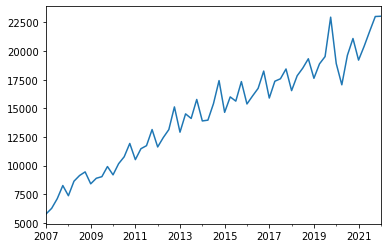

In [446]:
HH_transpose['Расходы на конечное потребление- всего'].plot()

In [448]:
HH_transpose['Time']=HH_transpose.index

In [450]:
HH_transpose.Time

2007Q1    2007Q1
2007Q2    2007Q2
2007Q3    2007Q3
2007Q4    2007Q4
2008Q1    2008Q1
           ...  
2021Q1    2021Q1
2021Q2    2021Q2
2021Q3    2021Q3
2021Q4    2021Q4
2022Q1    2022Q1
Freq: Q-DEC, Name: Time, Length: 61, dtype: period[Q-DEC]

In [473]:
names(HH_transpose)

NameError: name 'names' is not defined

In [489]:
HH_transpose=HH_transpose.rename(columns={'Расходы на конечное потребление- всего':'Total_consumption'})

In [482]:
HH_transpose['numb']=range(len(HH_transpose))

In [490]:
HH_transpose

,Total_consumption,домашнее питание,денежные расходы,стоимость натуральных поступлений продуктов питания,поступлений из личного подсобного хозяйства,полученных подарков и других поступлений,"алкогольные напитки, табачные изделия",одежду и обувь,жилищно-коммунальные услуги и ТОПЛИВО,"предметы домашнего обихода, бытовую технику и уход за домом",...,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам",Потребительские расходы- всего,Справочно: из общей суммы расходов на потребление: расходы на питание,расходы на непродовольственные товары,расходы на алкогольные напитки,расходы на оплату услуг,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам","финансовые услуги, услуги страхования",Time,numb
2007Q1,5768.200,1939.000000,1627.900000,311.100,255.900000,55.200000,145.300000,518.200000,677.600000,395.100000,...,7.500000,5445.700,NaN,NaN,NaN,NaN,NaN,NaN,2007Q1,0
2007Q2,6254.400,2022.000000,1760.500000,261.500,207.000000,54.500000,141.100000,537.700000,725.700000,391.600000,...,15.100000,5977.400,NaN,NaN,NaN,NaN,NaN,NaN,2007Q2,1
2007Q3,7099.100,2120.700000,1835.700000,285.000,216.200000,68.800000,151.400000,639.400000,845.900000,503.700000,...,13.500000,6830.700,NaN,NaN,NaN,NaN,NaN,NaN,2007Q3,2
2007Q4,8248.500,2462.700000,2126.100000,336.600,272.300000,64.300000,196.500000,1014.500000,795.400000,612.000000,...,10.600000,7909.000,NaN,NaN,NaN,NaN,NaN,NaN,2007Q4,3
2008Q1,7359.200,2483.100000,2115.600000,367.500,295.700000,71.800000,166.500000,693.300000,768.000000,522.400000,...,12.500000,6972.300,NaN,NaN,NaN,NaN,NaN,NaN,2008Q1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q1,19212.541,6382.719555,5737.699555,645.020,490.456464,154.563536,285.820901,2605.547848,2043.570796,961.188575,...,36.506077,18514.584,7108.914,6501.451,299.360,5266.310,36.506077,154.915724,2021Q1,56
2021Q2,20419.658,7012.619000,6428.624000,583.995,433.074000,150.921000,569.997000,1378.303000,2226.251000,1065.495000,...,56.722000,19791.086,7496.415,6987.527,292.316,5586.690,56.722000,181.924000,2021Q2,57
2021Q3,21742.005,7105.832000,6412.105000,693.727,487.294000,206.433000,619.041000,1805.618000,2155.801000,1232.345000,...,73.465000,21072.360,7625.406,7802.620,305.049,5935.472,73.465000,195.938000,2021Q3,58
2021Q4,23024.478,7865.368000,7198.082000,667.286,506.799000,160.487000,703.314000,1980.783000,2491.375000,1216.956000,...,48.374000,22427.468,8432.327,8282.488,382.909,5878.416,48.374000,284.445000,2021Q4,59


In [491]:
reg=smf.ols(formula='Total_consumption~numb',data=HH_transpose)
results=reg.fit()

In [492]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      Total_consumption   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     971.9
Date:                Sun, 14 Aug 2022   Prob (F-statistic):           2.38e-38
Time:                        23:04:20   Log-Likelihood:                -512.28
No. Observations:                  61   AIC:                             1029.
Df Residuals:                      59   BIC:                             1033.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7196.7152    276.232     26.053      0.0

In [493]:
acon=results.fittedvalues
HH_transpose['detrended']=HH_transpose['Total_consumption']-acon
HH_transpose['Acon']=acon
HH_transpose.head()

,Total_consumption,домашнее питание,денежные расходы,стоимость натуральных поступлений продуктов питания,поступлений из личного подсобного хозяйства,полученных подарков и других поступлений,"алкогольные напитки, табачные изделия",одежду и обувь,жилищно-коммунальные услуги и ТОПЛИВО,"предметы домашнего обихода, бытовую технику и уход за домом",...,Справочно: из общей суммы расходов на потребление: расходы на питание,расходы на непродовольственные товары,расходы на алкогольные напитки,расходы на оплату услуг,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам","финансовые услуги, услуги страхования",Time,numb,detrended,Acon
2007Q1,5768.2,1939.0,1627.9,311.1,255.9,55.2,145.3,518.2,677.6,395.1,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q1,0,-1428.515195,7196.715195
2007Q2,6254.4,2022.0,1760.5,261.5,207.0,54.5,141.1,537.7,725.7,391.6,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q2,1,-1189.887257,7444.287257
2007Q3,7099.1,2120.7,1835.7,285.0,216.2,68.8,151.4,639.4,845.9,503.7,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q3,2,-592.759320,7691.859320
2007Q4,8248.5,2462.7,2126.1,336.6,272.3,64.3,196.5,1014.5,795.4,612.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q4,3,309.068618,7939.431382
2008Q1,7359.2,2483.1,2115.6,367.5,295.7,71.8,166.5,693.3,768.0,522.4,...,NaN,NaN,NaN,NaN,NaN,NaN,2008Q1,4,-827.803445,8187.003445


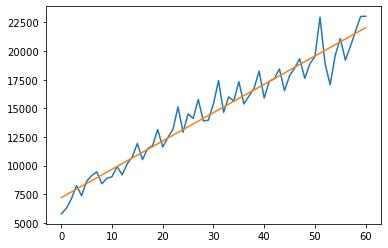

In [494]:
plt.plot("numb","Total_consumption",data=HH_transpose)
plt.plot(HH_transpose["numb"],acon)

In [495]:
HH_transpose=sm.add_constant(HH_transpose)

In [501]:
for i in range(len(HH_transpose.columns)):
    print(i,HH_transpose.columns[i])

0 const
1 Total_consumption
2 домашнее питание
3     денежные расходы
4 стоимость натуральных поступлений продуктов питания
5 поступлений из личного подсобного хозяйства
6 полученных подарков и других поступлений
7 алкогольные напитки, табачные    изделия
8 одежду и обувь
9 жилищно-коммунальные услуги и ТОПЛИВО
10 предметы домашнего обихода,    бытовую технику и уход за домом
11 здравоохранение
12 транспорт
13 связь
14 организацию отдыха и культурные    мероприятия
15 образование
16 гостиницы, кафе и рестораны
17 другие товары и услуги
18 стоимость услуг, предоставленных  работодателем бесплатно или по  льготным ценам
19 Потребительские расходы- всего
20 Справочно: из общей суммы расходов на потребление: расходы на питание
21 расходы на непродовольственные товары
22 расходы на алкогольные напитки
23 расходы на оплату услуг
24 стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам
25 финансовые услуги, услуги страхования
26 Time
27 numb
28 detrended
29 Acon


In [ ]:
HH_transpose=HH_transpose.rename(columns={'домашнее питание':'homemade_food'})
HH_transpose=HH_transpose.rename(columns={"алкогольные напитки, табачные    изделия":"Alcohol_tobacco"})
HH_transpose=HH_transpose.rename(columns={HH_transpose.columns[8]:'clothing_shoes'})

жилищно-коммунальные услуги и ТОПЛИВО

In [503]:
HH_transpose[HH_transpose.columns[0]]

2007Q1    1.0
2007Q2    1.0
2007Q3    1.0
2007Q4    1.0
2008Q1    1.0
         ... 
2021Q1    1.0
2021Q2    1.0
2021Q3    1.0
2021Q4    1.0
2022Q1    1.0
Freq: Q-DEC, Name: const, Length: 61, dtype: float64

In [1406]:
HH_transpose

,const,Total_consumption,домашнее питание,денежные расходы,стоимость натуральных поступлений продуктов питания,поступлений из личного подсобного хозяйства,полученных подарков и других поступлений,"алкогольные напитки, табачные изделия",одежду и обувь,жилищно-коммунальные услуги и ТОПЛИВО,...,Справочно: из общей суммы расходов на потребление: расходы на питание,расходы на непродовольственные товары,расходы на алкогольные напитки,расходы на оплату услуг,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам","финансовые услуги, услуги страхования",Time,numb,detrended,Acon
2007Q1,1.0,5768.200,1939.000000,1627.900000,311.100,255.900000,55.200000,145.300000,518.200000,677.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q1,0,-1428.515195,7196.715195
2007Q2,1.0,6254.400,2022.000000,1760.500000,261.500,207.000000,54.500000,141.100000,537.700000,725.700000,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q2,1,-1189.887257,7444.287257
2007Q3,1.0,7099.100,2120.700000,1835.700000,285.000,216.200000,68.800000,151.400000,639.400000,845.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q3,2,-592.759320,7691.859320
2007Q4,1.0,8248.500,2462.700000,2126.100000,336.600,272.300000,64.300000,196.500000,1014.500000,795.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q4,3,309.068618,7939.431382
2008Q1,1.0,7359.200,2483.100000,2115.600000,367.500,295.700000,71.800000,166.500000,693.300000,768.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,2008Q1,4,-827.803445,8187.003445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q1,1.0,19212.541,6382.719555,5737.699555,645.020,490.456464,154.563536,285.820901,2605.547848,2043.570796,...,7108.914,6501.451,299.360,5266.310,36.506077,154.915724,2021Q1,56,-1848.209687,21060.750687
2021Q2,1.0,20419.658,7012.619000,6428.624000,583.995,433.074000,150.921000,569.997000,1378.303000,2226.251000,...,7496.415,6987.527,292.316,5586.690,56.722000,181.924000,2021Q2,57,-888.664749,21308.322749
2021Q3,1.0,21742.005,7105.832000,6412.105000,693.727,487.294000,206.433000,619.041000,1805.618000,2155.801000,...,7625.406,7802.620,305.049,5935.472,73.465000,195.938000,2021Q3,58,186.110189,21555.894811
2021Q4,1.0,23024.478,7865.368000,7198.082000,667.286,506.799000,160.487000,703.314000,1980.783000,2491.375000,...,8432.327,8282.488,382.909,5878.416,48.374000,284.445000,2021Q4,59,1221.011126,21803.466874


In [506]:
equations = OrderedDict()
equations['home-made food'] = {'dependent': HH_transpose[HH_transpose.columns[2]],
                         'exog': HH_transpose[[ 'const','detrended']]}
equations['closing and shoes'] = {'dependent': HH_transpose[HH_transpose.columns[8]],
                         'exog': HH_transpose[[ 'const','detrended']]}
mod = SUR(equations)

In [507]:
print(mod.fit(cov_type='unadjusted'))

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.0242
No. Equations.:                     2   McElroy's R-squared:                 0.2436
No. Observations:                  61   Judge's (OLS) R-squared:             0.0242
Date:                Sun, Aug 14 2022   Berndt's R-squared:                  0.3918
Time:                        23:19:23   Dhrymes's R-squared:                 0.0242
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
        Equation: home-made food, Dependent Variable: домашнее питание        
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4732.5     194.72     24.305     0.0000      4350.9      5114.2
detrended   

## Кросс-секционные данные по регионам России за 2020

### Загрузка библиотек

In [2255]:
#Нужна библиотека для чтения CSV
#Библиотека для работы с датафреймами
import pandas as pd
#Для простой регрессии
import statsmodels.formula.api as smf
#Для графиков
import matplotlib.pyplot as plt
#Нам нужен упорядоченный словарь для системы уравнений
from collections import OrderedDict
#Понадобится для добавления константы
import statsmodels.api as sm
#Для оценки систем одновременных уравнений
from linearmodels.system import SUR
#Для статистических тестов
from scipy import stats
#Для графиков
import seaborn as sns

### Работа с данными

https://showdata.gks.ru/report/277338/ - величина прожитоного минимума

В Excel я объединил данные по потреблению по регионам, население регионов, прожиточный минимум  росстата

In [2259]:
#Получаем сырые данные
Households_crude = pd.read_excel(r'C:\Users\79618\Desktop\(3 курс) Курсовая работа\Data\ДХ ПО РЕГИОНАМ 2020.xlsx',header=0)
Households_crude.head(2)

,Номер,Регион,"Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020",ДОМАШНЕЕ ПИТАНИЕ,ДП: денежные расходы,ДП: стоимость натуральных поступлений,СТП: поступлений из дичного подсобного хозяйтсва,СТП: полученных подарков и других поступлений,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,...,"ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г.","Все население, 2020","Старше трудоспособного возраста, 2020","Все население, 2021","Старше трудоспособного возраста, 2021"
0,0,Российская Федерация,19180.790,34.984690,31.765829,3.218861,2.305630,0.913226,3.179275,6.687472,...,10843.0,11468.0,11605.99,11328.99,11653.0,13918.99,146748.6,36628.6,146171.0,36902.8
1,1,Белгородская область,19641.113,36.690787,31.325419,5.365368,3.613573,1.751795,3.575836,6.071881,...,9236.0,9382.0,9395.00,9592.99,9720.0,11691.99,1549.2,421.2,1541.3,423.8


In [2260]:
Households_relative=Households_crude.loc[:,
                    ['Номер',
                     'Регион',
                     'Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020',
                     'ДОМАШНЕЕ ПИТАНИЕ',
                     'АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ',
                     'ОДЕЖДУ И ОБУВЬ',
                     'ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА',
                     'МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА',
                     'ЗДРАВООХРАНЕНИЕ',
                     'ТРАНСПОРТ',
                     'ИНФОРМАЦИЯ И КОММУНИКАЦИЯ',
                     'ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ',
                     'ОБРАЗОВАНИЕ', 'ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ',
                     'ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ',
                     'ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ',
                     'стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам',
                     'ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.',
                     'Все население, 2020']]


In [2261]:
#Переименовываем слишком длинные столбцы
Households_relative=Households_relative.rename(columns={'Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020':'Полное потребление'})
Households_relative=Households_relative.rename(columns={'стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам':'УСЛУГИ РАБОТОДАТЕЛЕЙ'})

In [2262]:
#Удаляем федеральные округа
Households_relative.tail(9)
Households_relative=Households_relative.iloc[:-8]

In [2164]:
#MINIMA - разница между потребительскими расходами ДХ и прожиточным минимумом в регионе
Households_relative['MINIMA']=Households_relative["Полное потребление"]-Households_relative["ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г."]
Households_relative.head(5)

,Номер,Регион,Полное потребление,ДОМАШНЕЕ ПИТАНИЕ,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА","МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА",ЗДРАВООХРАНЕНИЕ,ТРАНСПОРТ,ИНФОРМАЦИЯ И КОММУНИКАЦИЯ,"ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ",ОБРАЗОВАНИЕ,"ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ",ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ,"ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ",УСЛУГИ РАБОТОДАТЕЛЕЙ,"ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.","Все население, 2020",MINIMA
0,0,Российская Федерация,19180.790,34.984690,3.179275,6.687472,11.493088,6.117386,3.829399,14.469420,3.273812,5.560908,0.827130,2.347036,1.000739,5.943375,0.286260,11328.99,146748.6,7851.800
1,1,Белгородская область,19641.113,36.690787,3.575836,6.071881,9.006511,5.923432,3.535344,18.480526,3.024416,5.359437,0.922794,1.442698,0.813140,4.829228,0.323968,9592.99,1549.2,10048.123
2,2,Брянская область,15389.084,42.413226,2.325700,7.473011,9.510358,6.128195,2.972399,12.905440,3.419086,4.042450,0.079270,2.500838,0.866787,5.147834,0.215399,10950.00,1192.5,4439.084
3,3,Владимирская область,15381.744,42.336240,3.126037,6.612157,12.166221,6.075657,4.703296,9.359231,4.084316,4.123577,0.575890,0.966353,0.839045,4.983077,0.048889,10807.99,1358.4,4573.754
4,4,Воронежская область,15489.427,41.804258,4.433127,5.785818,11.870032,5.752976,4.382628,9.593828,3.402579,3.374741,1.887733,0.614574,1.011364,6.006475,0.079867,9053.00,2324.2,6436.427


In [2263]:
#Переводим категории потреб. расходов из процентных в абсолютные значения
Households_abs=Households_relative
Households_abs.loc[:,'ДОМАШНЕЕ ПИТАНИЕ':'УСЛУГИ РАБОТОДАТЕЛЕЙ']=(Households_relative.loc[:,'ДОМАШНЕЕ ПИТАНИЕ':'УСЛУГИ РАБОТОДАТЕЛЕЙ']/100).multiply(Households_relative['Полное потребление'], axis='index')
Households_abs.head(5)

,Номер,Регион,Полное потребление,ДОМАШНЕЕ ПИТАНИЕ,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА","МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА",ЗДРАВООХРАНЕНИЕ,ТРАНСПОРТ,ИНФОРМАЦИЯ И КОММУНИКАЦИЯ,"ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ",ОБРАЗОВАНИЕ,"ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ",ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ,"ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ",УСЛУГИ РАБОТОДАТЕЛЕЙ,"ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.","Все население, 2020"
0,0,Российская Федерация,19180.790,6710.340,609.810,1282.710,2204.465,1173.363,734.509,2775.349,627.943,1066.626,158.650,450.180,191.949699,1139.986301,54.907,11328.99,146748.6
1,1,Белгородская область,19641.113,7206.479,702.334,1192.585,1768.979,1163.428,694.381,3629.781,594.029,1052.653,181.247,283.362,159.709823,948.514177,63.631,9592.99,1549.2
2,2,Брянская область,15389.084,6527.007,357.904,1150.028,1463.557,943.073,457.425,1986.029,526.166,622.096,12.199,384.856,133.390554,792.204446,33.148,10950.00,1192.5
3,3,Владимирская область,15381.744,6512.052,480.839,1017.065,1871.377,934.542,723.449,1439.613,628.239,634.278,88.582,148.642,129.059805,766.484195,7.520,10807.99,1358.4
4,4,Воронежская область,15489.427,6475.240,686.666,896.190,1838.600,891.103,678.844,1486.029,527.040,522.728,292.399,95.194,156.654477,930.368523,12.371,9053.00,2324.2


In [2264]:
#Чтобы убрать ошибку округления, получаем новое значение потреб. расходов, складывая расходы по категориям
Households_abs['Полное потребление']=Households_abs.loc[:,'ДОМАШНЕЕ ПИТАНИЕ':'УСЛУГИ РАБОТОДАТЕЛЕЙ'].sum(axis=1)

In [2265]:
#Получаем веса регионов
Households_abs['Доля']=Households_abs.loc[:,'Все население, 2020']/Households_abs['Все население, 2020'][0]

In [2271]:
Households_abs

,Номер,Регион,Полное потребление,ДОМАШНЕЕ ПИТАНИЕ,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА","МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА",ЗДРАВООХРАНЕНИЕ,ТРАНСПОРТ,ИНФОРМАЦИЯ И КОММУНИКАЦИЯ,"ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ",ОБРАЗОВАНИЕ,"ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ",ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ,"ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ",УСЛУГИ РАБОТОДАТЕЛЕЙ,"ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.","Все население, 2020",Доля
0,0,Российская Федерация,19180.788,6710.340,609.810,1282.710,2204.465,1173.363,734.509,2775.349,627.943,1066.626,158.650,450.180,191.949699,1139.986301,54.907,11328.99,146748.6,1.000000
1,1,Белгородская область,19641.113,7206.479,702.334,1192.585,1768.979,1163.428,694.381,3629.781,594.029,1052.653,181.247,283.362,159.709823,948.514177,63.631,9592.99,1549.2,0.010557
2,2,Брянская область,15389.083,6527.007,357.904,1150.028,1463.557,943.073,457.425,1986.029,526.166,622.096,12.199,384.856,133.390554,792.204446,33.148,10950.00,1192.5,0.008126
3,3,Владимирская область,15381.742,6512.052,480.839,1017.065,1871.377,934.542,723.449,1439.613,628.239,634.278,88.582,148.642,129.059805,766.484195,7.520,10807.99,1358.4,0.009257
4,4,Воронежская область,15489.427,6475.240,686.666,896.190,1838.600,891.103,678.844,1486.029,527.040,522.728,292.399,95.194,156.654477,930.368523,12.371,9053.00,2324.2,0.015838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,78,Амурская область,18844.827,6106.459,488.682,1053.163,2181.356,926.084,1054.711,3839.737,739.387,763.891,202.795,64.713,204.623455,1215.255545,3.970,13529.99,790.0,0.005383
79,79,Магаданская область,30866.055,10383.879,676.468,2110.107,4352.638,1919.080,1085.864,3524.473,1216.126,1734.987,53.029,652.384,420.994306,2500.278694,235.747,20829.99,140.1,0.000955
80,80,Сахалинская область,28262.528,10062.414,700.047,1821.614,2723.923,1763.421,909.624,5157.369,910.613,1611.678,285.596,161.574,256.834120,1525.333880,372.487,16130.00,488.3,0.003327
81,81,Еврейская автономная область,18483.121,5665.107,1113.936,1222.966,1924.203,1727.175,645.738,3075.355,741.179,814.925,176.823,209.799,165.287584,981.640416,18.987,15415.99,158.3,0.001079


In [2170]:
Households_abs=Households_abs.iloc[1:,:]

In [2276]:
Households_abs.mean().iloc[1:-3].index

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\2987572105.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Households_abs.mean().iloc[1:-3].index


Index(['Полное потребление', 'ДОМАШНЕЕ ПИТАНИЕ', 'АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ',
       'ОДЕЖДУ И ОБУВЬ', 'ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА',
       'МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА', 'ЗДРАВООХРАНЕНИЕ',
       'ТРАНСПОРТ', 'ИНФОРМАЦИЯ И КОММУНИКАЦИЯ',
       'ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ',
       'ОБРАЗОВАНИЕ', 'ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ',
       'ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ',
       'ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ',
       'УСЛУГИ РАБОТОДАТЕЛЕЙ'],
      dtype='object')

In [2279]:
Households_abs.mean().iloc[2:-3].values

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\44716113.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Households_abs.mean().iloc[2:-3].values


array([6479.5440241 ,  549.21239759, 1228.27915663, 1987.88733735,
       1112.89385542,  689.08651807, 2528.08243373,  603.50987952,
        871.48092771,  123.13887952,  301.36108434,  174.40081496,
       1035.76375131,   57.22125301])

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\3710879563.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Households_abs.mean().iloc[1:-3]
C:\Users\79618\AppData\Local\Temp\ipykernel_17960\3710879563.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  labels = Households_abs.mean().iloc[2:-3].index
C:\Users\79618\AppData\Local\Temp\ipykernel_17960\3710879563.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sizes = list(Households_abs.mean().iloc[2:-3].values)


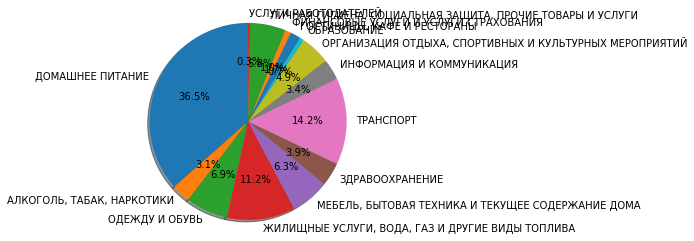

In [2280]:
Households_abs.mean().iloc[1:-3]
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = Households_abs.mean().iloc[2:-3].index
sizes = list(Households_abs.mean().iloc[2:-3].values)

fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [2282]:
# Находим категории <500 в среднем и агрегируем их в "прочие товары"
bad_goods=list(Households_abs.iloc[:,3:-4].mean()[(Households_abs.iloc[:,3:-4].mean()<500)].index)
bad_goods
Households_abs[bad_goods]
Households_abs['OTHER']=Households_abs[bad_goods].sum(axis=1)+Households_abs.loc[:,'ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ']
Households_abs_final=Households_abs.drop(columns=bad_goods+['ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ'])

In [2283]:
Households_abs_final.columns

Index(['Номер', 'Регион', 'Полное потребление', 'ДОМАШНЕЕ ПИТАНИЕ',
       'АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ', 'ОДЕЖДУ И ОБУВЬ',
       'ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА',
       'МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА', 'ЗДРАВООХРАНЕНИЕ',
       'ТРАНСПОРТ', 'ИНФОРМАЦИЯ И КОММУНИКАЦИЯ',
       'ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ',
       'УСЛУГИ РАБОТОДАТЕЛЕЙ', 'ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.',
       'Все население, 2020', 'Доля', 'OTHER'],
      dtype='object')

In [2284]:
# Переименовываем
Households_abs_final.columns=['numb', 'Region', 'Total_consumption', 'Food',
       'Alcohol_Tobacco', 'Cloth_Shoes',
       'Housing',
       'Furniture_Electronics_House maintenance', 'Healthcare',
       'Transport', 'IT_Communication',
       'Recreation',
       'Cost_of_Living', 'pop', 'MINIMA',
       'share', 'Other_goods']

In [2285]:
Households_abs_final

,numb,Region,Total_consumption,Food,Alcohol_Tobacco,Cloth_Shoes,Housing,Furniture_Electronics_House maintenance,Healthcare,Transport,IT_Communication,Recreation,Cost_of_Living,pop,MINIMA,share,Other_goods
0,0,Российская Федерация,19180.788,6710.340,609.810,1282.710,2204.465,1173.363,734.509,2775.349,627.943,1066.626,54.907,11328.99,146748.6,1.000000,1940.766
1,1,Белгородская область,19641.113,7206.479,702.334,1192.585,1768.979,1163.428,694.381,3629.781,594.029,1052.653,63.631,9592.99,1549.2,0.010557,1572.833
2,2,Брянская область,15389.083,6527.007,357.904,1150.028,1463.557,943.073,457.425,1986.029,526.166,622.096,33.148,10950.00,1192.5,0.008126,1322.650
3,3,Владимирская область,15381.742,6512.052,480.839,1017.065,1871.377,934.542,723.449,1439.613,628.239,634.278,7.520,10807.99,1358.4,0.009257,1132.768
4,4,Воронежская область,15489.427,6475.240,686.666,896.190,1838.600,891.103,678.844,1486.029,527.040,522.728,12.371,9053.00,2324.2,0.015838,1474.616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,78,Амурская область,18844.827,6106.459,488.682,1053.163,2181.356,926.084,1054.711,3839.737,739.387,763.891,3.970,13529.99,790.0,0.005383,1687.387
79,79,Магаданская область,30866.055,10383.879,676.468,2110.107,4352.638,1919.080,1085.864,3524.473,1216.126,1734.987,235.747,20829.99,140.1,0.000955,3626.686
80,80,Сахалинская область,28262.528,10062.414,700.047,1821.614,2723.923,1763.421,909.624,5157.369,910.613,1611.678,372.487,16130.00,488.3,0.003327,2229.338
81,81,Еврейская автономная область,18483.121,5665.107,1113.936,1222.966,1924.203,1727.175,645.738,3075.355,741.179,814.925,18.987,15415.99,158.3,0.001079,1533.550


In [2286]:
Households_abs_final=sm.add_constant(Households_abs_final)

### Оценка методом SUR

In [2287]:
equations = OrderedDict()
#1
equations['Food'] = {'dependent': Households_abs_final['Food'],
                         'exog': Households_abs_final[[ 'const','Total_consumption']]}
#2
equations['Alcohol_Tobacco'] = {'dependent': Households_abs_final['Alcohol_Tobacco'],
                         'exog': Households_abs_final[[ 'const','Total_consumption']]}
#3
equations['Cloth_Shoes'] = {'dependent': Households_abs_final["Cloth_Shoes"],
                         'exog': Households_abs_final[[ 'const','Total_consumption']]}
#4
equations['Housing'] = {'dependent': Households_abs_final["Housing"],
                         'exog': Households_abs_final[[ 'const','Total_consumption']]}
#5
equations['Furniture_Electronics_House maintenance'] = {'dependent': Households_abs_final["Furniture_Electronics_House maintenance"],
                         'exog': Households_abs_final[[ 'const','Total_consumption']]}
#6
#equations['Healthcare'] = {'dependent': Households_abs_final["Healthcare"],
#                        'exog': Households_abs_final[[ 'const','Total_consumption']]}
#7
equations['Transport'] = {'dependent': Households_abs_final["Transport"],
                         'exog': Households_abs_final[[ 'const','Total_consumption']]}
#8
equations['IT_Communication'] = {'dependent': Households_abs_final["IT_Communication"],
                         'exog': Households_abs_final[[ 'const','Total_consumption']]}
#9
equations['Recreation'] = {'dependent': Households_abs_final["Recreation"],
                         'exog': Households_abs_final[[ 'const','Total_consumption']]}
#10
equations['Other_goods'] = {'dependent': Households_abs_final["Other_goods"],
                         'exog': Households_abs_final[[ 'const','Total_consumption']]}


mod = SUR(equations)
print(mod.fit(cov_type='robust'))

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.6428
No. Equations.:                     9   McElroy's R-squared:                 0.9923
No. Observations:                  83   Judge's (OLS) R-squared:             0.6428
Date:                Fri, Aug 26 2022   Berndt's R-squared:                  0.9991
Time:                        06:57:49   Dhrymes's R-squared:                 0.6428
                                        Cov. Estimator:                      robust
                                        Num. Constraints:                      None
                       Equation: Food, Dependent Variable: Food                      
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 2529.6     350.64     7.2142     0.0000      184

### Работа с моделью

In [2290]:
pars_sur=pd.DataFrame(mod.fit(cov_type='robust').params)
pars_sur

,params
Food_const,2529.595954
Food_Total_consumption,0.222634
Alcohol_Tobacco_const,-188.233415
Alcohol_Tobacco_Total_consumption,0.041565
Cloth_Shoes_const,194.713138
Cloth_Shoes_Total_consumption,0.058256
Housing_const,-461.871235
Housing_Total_consumption,0.138078
Furniture_Electronics_House maintenance_const,21.564606
Furniture_Electronics_House maintenance_Total_consumption,0.061512


In [2291]:
alpha0=-pars_sur.loc[[match for match in list(pars_sur.index) if 'const' in match],:].sum().params
beta0=1-pars_sur.loc[[match for match in list(pars_sur.index) if 'Total_consumption' in match],:].sum().params
[alpha0,beta0]

[33.94926542041617, 0.04015128136417845]

In [2292]:
modfit=mod.fit(cov_type='robust')

In [2293]:
Households_fitted=modfit.fitted_values

In [2294]:
Households_fitted['Healthcare']=alpha0+beta0*Households_abs_final.Total_consumption

In [2295]:
Households_fitted["Total_consumption"]=Households_fitted.sum(axis=1)

In [2296]:
Households_fitted

,Food,Alcohol_Tobacco,Cloth_Shoes,Housing,Furniture_Electronics_House maintenance,Transport,IT_Communication,Recreation,Other_goods,Healthcare,Total_consumption
0,6799.898316,609.021774,1312.104894,2186.571132,1201.404388,2795.931066,649.814828,996.008284,1825.950837,804.082481,19180.788
1,6902.382475,628.155320,1338.921486,2250.131828,1229.719687,2881.618202,664.628188,1035.845682,1887.145011,822.565120,19641.113
2,5955.734520,451.418422,1091.216164,1663.020579,968.170780,2090.124639,527.796919,667.866947,1321.893364,651.840667,15389.083
3,5954.100161,451.113291,1090.788508,1662.006950,967.719224,2088.758150,527.560684,667.231643,1320.917474,651.545916,15381.742
4,5978.074541,455.589250,1097.061782,1676.875865,974.343094,2108.803160,531.026011,676.550907,1335.232783,655.869607,15489.427
...,...,...,...,...,...,...,...,...,...,...,...
78,6725.101856,595.057455,1292.533224,2140.182353,1180.738910,2733.393650,639.003528,966.933582,1781.289226,790.593217,18844.827
79,9401.440196,1094.723391,1992.839232,3800.047919,1920.183141,4971.083549,1025.849314,2007.273435,3379.353899,1273.260924,30866.055
80,8821.805642,986.507013,1841.168737,3440.558455,1760.036189,4486.450359,942.067237,1781.959275,3033.249115,1168.725979,28262.528
81,6644.573674,580.023037,1271.461759,2090.238759,1158.489818,2666.063934,627.363749,935.630859,1733.205155,776.070257,18483.121


In [2206]:
modfit.resids.describe()

,Food,Alcohol_Tobacco,Cloth_Shoes,Housing,Furniture_Electronics_House maintenance,Transport,IT_Communication,Recreation,Other_goods
count,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01,8.200000e+01
mean,2.653894e-10,1.916039e-11,4.964787e-12,5.055737e-11,4.018414e-11,-3.789598e-10,1.099574e-11,-2.749558e-11,2.816661e-11
std,7.090156e+02,1.640982e+02,2.137541e+02,2.851516e+02,2.276590e+02,8.423730e+02,8.786660e+01,2.159120e+02,3.290447e+02
min,-1.333188e+03,-4.182367e+02,-3.885749e+02,-9.398805e+02,-5.483064e+02,-2.266047e+03,-1.490179e+02,-6.031398e+02,-6.908272e+02
25%,-4.310835e+02,-1.121287e+02,-1.460085e+02,-1.646076e+02,-1.239708e+02,-4.563846e+02,-5.571240e+01,-1.276175e+02,-2.263570e+02
50%,-8.083263e+01,3.865106e+00,-9.228394e+00,3.204401e+01,-2.942215e+01,-2.136306e+01,-6.248796e+00,-3.068245e+01,2.356436e+01
75%,3.545852e+02,8.964183e+01,1.051144e+02,1.890916e+02,7.549411e+01,3.784123e+02,3.416879e+01,1.458025e+02,1.945299e+02
max,2.062737e+03,5.339231e+02,7.533030e+02,5.530138e+02,9.419677e+02,2.747285e+03,3.489625e+02,5.770432e+02,9.285899e+02


In [ ]:
Нужно ограничение, потому что сумма получилась меньше 1

In [2297]:
modfit.resids

,Food,Alcohol_Tobacco,Cloth_Shoes,Housing,Furniture_Electronics_House maintenance,Transport,IT_Communication,Recreation,Other_goods
0,-89.558316,0.788226,-29.394894,17.893868,-28.041388,-20.582066,-21.871828,70.617716,114.815163
1,304.096525,74.178680,-146.336486,-481.152828,-66.291687,748.162798,-70.599188,16.807318,-314.312011
2,571.272480,-93.514422,58.811836,-199.463579,-25.097780,-104.095639,-1.630919,-45.770947,0.756636
3,557.951839,29.725709,-73.723508,209.370050,-33.177224,-649.145150,100.678316,-32.953643,-188.149474
4,497.165459,231.076750,-200.871782,161.724135,-83.240094,-622.774160,-3.986011,-153.822907,139.383217
...,...,...,...,...,...,...,...,...,...
78,-618.642856,-106.375455,-239.370224,41.173647,-254.654910,1106.343350,100.383472,-203.042582,-93.902226
79,982.438804,-418.255391,117.267768,552.590081,-1.103141,-1446.610549,190.276686,-272.286435,247.332101
80,1240.608358,-286.460013,-19.554737,-716.635455,3.384811,670.918641,-31.454237,-170.281275,-803.911115
81,-979.466674,533.912963,-48.495759,-166.035759,568.685182,409.291066,113.815251,-120.705859,-199.655155


In [2209]:
Households_fitted

,Food,Alcohol_Tobacco,Cloth_Shoes,Housing,Furniture_Electronics_House maintenance,Transport,IT_Communication,Recreation,Other_goods,Healthcare,Total_consumption
1,6903.624670,628.144387,1339.329200,2249.883636,1230.108628,2881.903680,664.931555,1034.866198,1964.640872,743.680174,19641.113
2,5956.643925,451.410418,1091.514650,1662.838879,968.455522,2090.333636,528.019013,667.149871,1351.370686,621.346401,15389.083
3,5955.008992,451.105292,1091.086805,1661.825364,968.003786,2088.967015,527.782638,666.515020,1350.311893,621.135195,15381.742
4,5978.991801,455.581177,1097.362845,1676.692596,974.630295,2109.013962,531.250023,675.827638,1365.843298,624.233366,15489.427
5,6566.429967,565.214113,1251.089017,2040.852583,1136.940903,2600.046602,616.180634,903.932176,1746.271640,700.120365,18127.078
...,...,...,...,...,...,...,...,...,...,...,...
78,6726.281728,595.047070,1292.920483,2139.946613,1181.108337,2733.664805,639.291675,966.003240,1849.792561,720.770488,18844.827
79,9403.560919,1094.704726,1993.535297,3799.624196,1920.847155,4971.570928,1026.367234,2005.601221,3583.613992,1066.629330,30866.055
80,8823.722598,986.490141,1841.797922,3440.175444,1760.636403,4486.890909,942.535394,1780.447733,3208.107354,991.724101,28262.528
81,6645.725237,580.012901,1271.839726,2090.008675,1158.850381,2666.328583,627.644982,934.722839,1797.623713,710.363962,18483.121


In [2300]:
Households_abs_resids=modfit.resids
Households_abs_resids['Healthcare']=Households_abs_final['Healthcare']-Households_fitted['Healthcare']
Households_abs_resids["Total_consumption"]=Households_abs_final["Total_consumption"]-Households_fitted["Total_consumption"]

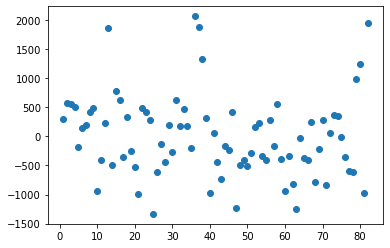

In [2213]:
plt.scatter(Households_abs_resids.iloc[:,0].index,Households_abs_resids.iloc[:,0])

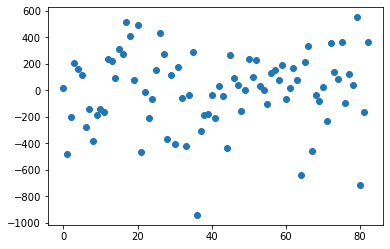

In [2302]:
x=3
plt.scatter(Households_abs_resids.iloc[:,x].index,Households_abs_resids.iloc[:,x])

Тест Шапиро-Уилка на нормальность (остатков).

In [2315]:
p0=0.05
for i in range(len(Households_abs_resids.columns)):
    stat,p=stats.shapiro(Households_abs_resids.iloc[:,i])
    if p>p0:
        print(i,'.',Households_abs_resids.columns[i],':' )
        print( round(p,2), ">", p0, "Нормальные остатки")
        print()
    else:
        print(i,'.',Households_abs_resids.columns[i],':')
        print(round(p,2), "<", p0, "НЕ НОРМАЛЬНЫЕ остатки!!!!!!!!")
        print()

0 . Food :
0.0 < 0.05 НЕ НОРМАЛЬНЫЕ остатки!!!!!!!!

1 . Alcohol_Tobacco :
0.04 < 0.05 НЕ НОРМАЛЬНЫЕ остатки!!!!!!!!

2 . Cloth_Shoes :
0.0 < 0.05 НЕ НОРМАЛЬНЫЕ остатки!!!!!!!!

3 . Housing :
0.07 > 0.05 Нормальные остатки

4 . Furniture_Electronics_House maintenance :
0.0 < 0.05 НЕ НОРМАЛЬНЫЕ остатки!!!!!!!!

5 . Transport :
0.0 < 0.05 НЕ НОРМАЛЬНЫЕ остатки!!!!!!!!

6 . IT_Communication :
0.0 < 0.05 НЕ НОРМАЛЬНЫЕ остатки!!!!!!!!

7 . Recreation :
0.55 > 0.05 Нормальные остатки

8 . Other_goods :
0.51 > 0.05 Нормальные остатки

9 . Healthcare :
0.57 > 0.05 Нормальные остатки

10 . Total_consumption :
0.0 < 0.05 НЕ НОРМАЛЬНЫЕ остатки!!!!!!!!



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


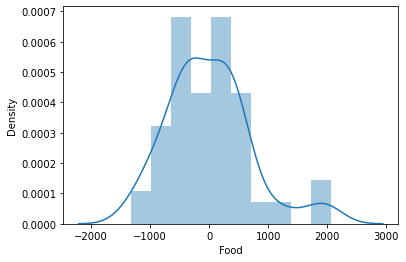

In [2231]:
ax=sns.distplot(Households_abs_resids.iloc[:,0])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


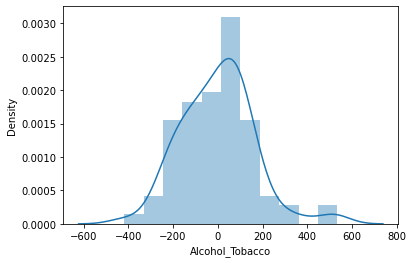

In [2230]:
ax=sns.distplot(Households_abs_resids.iloc[:,1])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


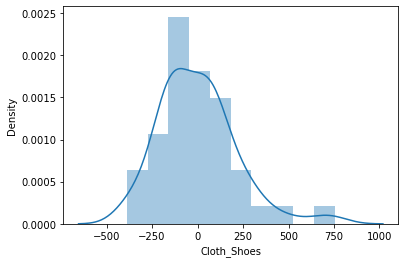

In [2232]:
ax=sns.distplot(Households_abs_resids.iloc[:,2])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


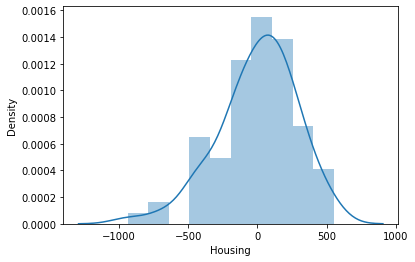

In [2233]:
ax=sns.distplot(Households_abs_resids.iloc[:,3])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


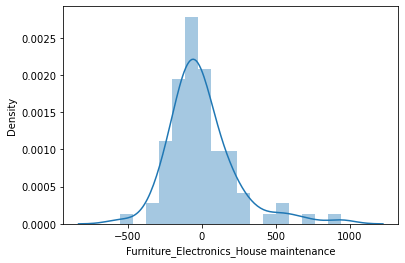

In [2234]:
ax=sns.distplot(Households_abs_resids.iloc[:,4])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


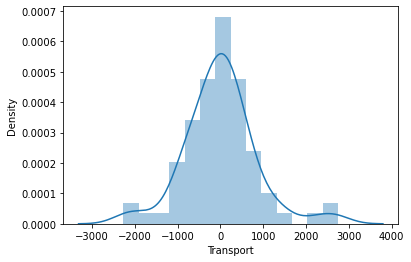

In [2235]:
ax=sns.distplot(Households_abs_resids.iloc[:,5])

In [2253]:
Households_abs_resids.T.dot(Households_abs_resids)

,Food,Alcohol_Tobacco,Cloth_Shoes,Housing,Furniture_Electronics_House maintenance,Transport,IT_Communication,Recreation,Other_goods,Healthcare,Total_consumption
Food,4.071895e+07,-3.530115e+05,6.211246e+05,-2.211419e+06,1.433214e+06,-2.800823e+07,3.276246e+05,-5.725316e+06,-4.405745e+06,-2.397201e+06,1.821848e-09
Alcohol_Tobacco,-3.530115e+05,2.181187e+06,-5.441110e+05,4.095885e+05,3.513165e+05,-2.344257e+06,-1.234439e+04,8.928708e+04,3.523214e+05,-1.299758e+05,4.658954e-10
Cloth_Shoes,6.211246e+05,-5.441110e+05,3.700954e+06,-1.680934e+06,1.464615e+05,-4.534277e+06,2.815686e+05,-1.723494e+05,2.353760e+06,-1.721978e+05,7.217413e-09
Housing,-2.211419e+06,4.095885e+05,-1.680934e+06,6.586227e+06,-1.944780e+05,-5.039235e+06,3.755095e+05,3.760310e+05,1.009373e+06,3.693373e+05,-6.670747e-10
Furniture_Electronics_House maintenance,1.433214e+06,3.513165e+05,1.464615e+05,-1.944780e+05,4.198120e+06,-6.159918e+06,3.687749e+05,-4.903997e+05,9.320483e+05,-5.851383e+05,1.340046e-09
Transport,-2.800823e+07,-2.344257e+06,-4.534277e+06,-5.039235e+06,-6.159918e+06,5.747698e+07,-1.441257e+06,5.156332e+05,-1.106831e+07,6.028638e+05,-8.227726e-09
IT_Communication,3.276246e+05,-1.234439e+04,2.815686e+05,3.755095e+05,3.687749e+05,-1.441257e+06,6.253636e+05,-5.109164e+05,6.358321e+04,-7.790684e+04,-7.447700e-10
Recreation,-5.725316e+06,8.928708e+04,-1.723494e+05,3.760310e+05,-4.903997e+05,5.156332e+05,-5.109164e+05,3.776056e+06,1.615531e+06,5.264431e+05,-2.358938e-09
Other_goods,-4.405745e+06,3.523214e+05,2.353760e+06,1.009373e+06,9.320483e+05,-1.106831e+07,6.358321e+04,1.615531e+06,8.769903e+06,3.775316e+05,3.961794e-09
Healthcare,-2.397201e+06,-1.299758e+05,-1.721978e+05,3.693373e+05,-5.851383e+05,6.028638e+05,-7.790684e+04,5.264431e+05,3.775316e+05,1.486244e+06,-2.808489e-09


In [2246]:
modfit.breusch_pagan()

Breusch-Pagan LM Test
H0: Residuals are uncorrelated
Statistic: 167.3940
P-value: 0.0000
Distributed: chi2(36)
WaldTestStatistic, id: 0x1fe34168b50

In [2247]:
modfit.likelihood_ratio()

Likelihood Ratio Test for Diagonal Covariance
H0: Covariance is diagonal
Statistic: 418.9338
P-value: 0.0000
Distributed: chi2(36)
WaldTestStatistic, id: 0x1fe3380d610

In [2248]:
modfit.sigma

,Food,Alcohol_Tobacco,Cloth_Shoes,Housing,Furniture_Electronics_House maintenance,Transport,IT_Communication,Recreation,Other_goods
Food,496572.616099,-4305.018877,7574.690084,-26968.520752,17478.215127,-341563.720358,3995.421600,-69820.929215,-53728.592270
Alcohol_Tobacco,-4305.018877,26599.835522,-6635.500202,4994.981788,4284.347158,-28588.502670,-150.541297,1088.866871,4296.602459
Cloth_Shoes,7574.690084,-6635.500202,45133.590268,-20499.198475,1786.116126,-55296.060016,3433.763640,-2101.822322,28704.394383
Housing,-26968.520752,4994.981788,-20499.198475,80319.836743,-2371.682765,-61454.084379,4579.384082,4585.743567,12309.426354
Furniture_Electronics_House maintenance,17478.215127,4284.347158,1786.116126,-2371.682765,51196.580856,-75120.956447,4497.255098,-5980.484174,11366.442234
Transport,-341563.720358,-28588.502670,-55296.060016,-61454.084379,-75120.956447,700938.771833,-17576.302934,6288.209780,-134979.352607
IT_Communication,3995.421600,-150.541297,3433.763640,4579.384082,4497.255098,-17576.302934,7626.385702,-6230.687484,775.405042
Recreation,-69820.929215,1088.866871,-2101.822322,4585.743567,-5980.484174,6288.209780,-6230.687484,46049.468168,19701.597216
Other_goods,-53728.592270,4296.602459,28704.394383,12309.426354,11366.442234,-134979.352607,775.405042,19701.597216,106950.033833


In [2249]:
import scipy.stats.mstats

In [1489]:
import statsmodels.formula.api as smf

In [1491]:
reg=smf.ols(formula='Food~Total_consumption	',data=Households_abs4)
ress=reg.fit()

In [1492]:
ress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Food   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     150.6
Date:                Thu, 18 Aug 2022   Prob (F-statistic):           8.40e-20
Time:                        08:42:43   Log-Likelihood:                -627.33
No. Observations:                  79   AIC:                             1259.
Df Residuals:                      77   BIC:                             1263.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2637.8547    322.314      8.184      0.000    1996.046    3279.663
Total_consumption     0.2153      0.018     12.271      0.000       0.180       0.250
==============================================================================
Omnibus:                        9.475   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.361
Skew:                           0.713   Prob(JB):                      0.00928
Kurtosis:                       3.901   Cond. No.                     7.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Лишнее

Проверим на то, что каждый прожиточный минимум ниже расходов на потребление

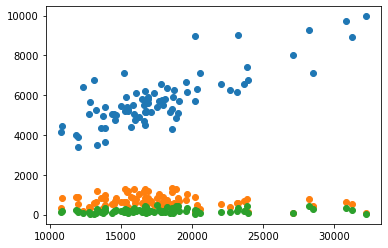

In [1141]:
plt.scatter(Households4.iloc[:,2],Households4.iloc[:,4])
plt.scatter(Households4.iloc[:,2],Households4.iloc[:,5])
plt.scatter(Households4.iloc[:,2],Households4.iloc[:,7])

In [1143]:
Households4=Households4.rename(columns={'Номер': "numb"})
Households4.head()

,numb,Регион,"Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020",ДОМАШНЕЕ ПИТАНИЕ,ДП: денежные расходы,ДП: стоимость натуральных поступлений,СТП: поступлений из дичного подсобного хозяйтсва,СТП: полученных подарков и других поступлений,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,...,ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ,"ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ","стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам","ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г.",MINIMA
9,9,Белгородская область,19641.113,7206.479,6152.661,1053.818,709.746,344.072,702.334,1192.585,...,159.709823,948.514177,63.631,9236.0,9382.00,9395.00,9592.99,9720.00,11691.99,9921.113
10,10,Брянская область,15389.084,6527.007,5391.810,1135.197,930.147,205.049,357.904,1150.028,...,133.390554,792.204446,33.148,10537.0,11280.00,11341.99,10950.00,11280.00,13127.00,4109.084
11,11,Владимирская область,15381.744,6512.052,5882.779,629.273,480.900,148.374,480.839,1017.065,...,129.059805,766.484195,7.520,10280.0,11092.99,11178.00,10807.99,11092.99,13501.00,4288.754
12,12,Воронежская область,15489.427,6475.240,5315.575,1159.665,958.520,201.145,686.666,896.190,...,156.654477,930.368523,12.371,8894.0,9362.00,9269.00,9053.00,9747.00,11831.99,5742.427
13,13,Ивановская область,18127.078,6379.709,5810.276,569.433,416.571,152.862,924.488,1272.686,...,187.693745,1114.710255,50.486,10123.0,10760.99,10965.00,10580.99,10760.99,12806.00,7366.088


In [1144]:
Households4.numb=range(79)

ValueError: Length of values (79) does not match length of index (82)

In [865]:
Households4.index=range(79)

In [866]:
Households4

,numb,Регион,"Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020",ДОМАШНЕЕ ПИТАНИЕ,ДП: денежные расходы,ДП: стоимость натуральных поступлений,СТП: поступлений из дичного подсобного хозяйтсва,СТП: полученных подарков и других поступлений,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,...,ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ,"ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ","стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам","ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г.",MINIMA
0,0,Белгородская область,19641.113,7206.479,6152.661,1053.818,709.746,344.072,702.334,1192.585,...,159.709823,948.514177,63.631,9236.00,9382.00,9395.00,9592.99,9720.00,11691.99,10048.123
1,1,Брянская область,15389.084,6527.007,5391.810,1135.197,930.147,205.049,357.904,1150.028,...,133.390554,792.204446,33.148,10537.00,11280.00,11341.99,10950.00,11280.00,13127.00,4439.084
2,2,Владимирская область,15381.744,6512.052,5882.779,629.273,480.900,148.374,480.839,1017.065,...,129.059805,766.484195,7.520,10280.00,11092.99,11178.00,10807.99,11092.99,13501.00,4573.754
3,3,Воронежская область,15489.427,6475.240,5315.575,1159.665,958.520,201.145,686.666,896.190,...,156.654477,930.368523,12.371,8894.00,9362.00,9269.00,9053.00,9747.00,11831.99,6436.427
4,4,Ивановская область,18127.078,6379.709,5810.276,569.433,416.571,152.862,924.488,1272.686,...,187.693745,1114.710255,50.486,10123.00,10760.99,10965.00,10580.99,10760.99,12806.00,7546.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,Хабаровский край,23689.475,7204.255,6539.595,664.661,473.241,191.420,673.024,1738.625,...,265.368654,1576.020346,93.800,14771.00,15319.99,15569.00,15569.00,16221.99,18557.99,8120.475
75,75,Амурская область,18844.826,6106.459,4834.320,1272.140,851.574,420.566,488.682,1053.163,...,204.623455,1215.255545,3.970,12525.00,12949.99,13280.99,13529.99,14016.99,16174.00,5314.836
76,76,Магаданская область,30866.054,10383.879,9743.896,639.983,310.061,329.922,676.468,2110.107,...,420.994306,2500.278694,235.747,19996.99,20588.00,21101.99,20829.99,21101.99,24219.99,10036.064
77,77,Сахалинская область,28262.529,10062.414,9282.030,780.384,355.926,424.459,700.047,1821.614,...,256.834120,1525.333880,372.487,15211.99,15905.99,16408.00,16130.00,15905.99,18930.00,12132.529


In [867]:
Households4=Households4.rename(columns={Households4.columns[2]: "Total_consumption"})
Households4

,numb,Регион,Total_consumption,ДОМАШНЕЕ ПИТАНИЕ,ДП: денежные расходы,ДП: стоимость натуральных поступлений,СТП: поступлений из дичного подсобного хозяйтсва,СТП: полученных подарков и других поступлений,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,...,ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ,"ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ","стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам","ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г.",MINIMA
0,0,Белгородская область,19641.113,7206.479,6152.661,1053.818,709.746,344.072,702.334,1192.585,...,159.709823,948.514177,63.631,9236.00,9382.00,9395.00,9592.99,9720.00,11691.99,10048.123
1,1,Брянская область,15389.084,6527.007,5391.810,1135.197,930.147,205.049,357.904,1150.028,...,133.390554,792.204446,33.148,10537.00,11280.00,11341.99,10950.00,11280.00,13127.00,4439.084
2,2,Владимирская область,15381.744,6512.052,5882.779,629.273,480.900,148.374,480.839,1017.065,...,129.059805,766.484195,7.520,10280.00,11092.99,11178.00,10807.99,11092.99,13501.00,4573.754
3,3,Воронежская область,15489.427,6475.240,5315.575,1159.665,958.520,201.145,686.666,896.190,...,156.654477,930.368523,12.371,8894.00,9362.00,9269.00,9053.00,9747.00,11831.99,6436.427
4,4,Ивановская область,18127.078,6379.709,5810.276,569.433,416.571,152.862,924.488,1272.686,...,187.693745,1114.710255,50.486,10123.00,10760.99,10965.00,10580.99,10760.99,12806.00,7546.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,Хабаровский край,23689.475,7204.255,6539.595,664.661,473.241,191.420,673.024,1738.625,...,265.368654,1576.020346,93.800,14771.00,15319.99,15569.00,15569.00,16221.99,18557.99,8120.475
75,75,Амурская область,18844.826,6106.459,4834.320,1272.140,851.574,420.566,488.682,1053.163,...,204.623455,1215.255545,3.970,12525.00,12949.99,13280.99,13529.99,14016.99,16174.00,5314.836
76,76,Магаданская область,30866.054,10383.879,9743.896,639.983,310.061,329.922,676.468,2110.107,...,420.994306,2500.278694,235.747,19996.99,20588.00,21101.99,20829.99,21101.99,24219.99,10036.064
77,77,Сахалинская область,28262.529,10062.414,9282.030,780.384,355.926,424.459,700.047,1821.614,...,256.834120,1525.333880,372.487,15211.99,15905.99,16408.00,16130.00,15905.99,18930.00,12132.529


In [892]:
good_goods=[]
bad_goods=[]
for i in range(len(Households4.mean())):
    if Households4.mean()[i]<500:
        x='!!!!!!!!!!!'
        bad_goods.append(i)
    else:
        x=''
        good_goods.append(i)
    print(i,Households4.mean().index[i],Households4.mean()[i],x)

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\1422788337.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  for i in range(len(Households4.mean())):
C:\Users\79618\AppData\Local\Temp\ipykernel_17960\1422788337.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if Households4.mean()[i]<500:
C:\Users\79618\AppData\Local\Temp\ipykernel_17960\1422788337.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(i,Households4.mean().index[i],Households4.mean()[i],x)


0 numb 39.0 !!!!!!!!!!!
1 Total_consumption 17829.391354430383 
2 ДОМАШНЕЕ ПИТАНИЕ 6477.0665443038 
3 ДП: денежные расходы 5773.59740506329 
4 ДП: стоимость натуральных поступлений 703.4691518987343 
5 СТП: поступлений из дичного подсобного хозяйтсва 507.4170759493671 
6 СТП: полученных подарков и других поступлений 196.05218987341775 !!!!!!!!!!!
7 АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ 550.757075949367 
8 ОДЕЖДУ И ОБУВЬ 1235.2223291139244 
9 ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА 1996.9386708860766 
10 МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА 1104.794949367089 
11 ЗДРАВООХРАНЕНИЕ 696.7455443037979 
12 ТРАНСПОРТ 2572.8029113924053 
13 ИНФОРМАЦИЯ И КОММУНИКАЦИЯ 601.3148481012659 
14 ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ 885.3655316455697 
15 ОБРАЗОВАНИЕ
 125.89808860759494 !!!!!!!!!!!
16 ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ 308.9161645569619 !!!!!!!!!!!
17 ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ 175.57009059432852 !!!!!!!!!!!
18 ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ Т

Все товара с потреблением ниже 500 агрегируются в 1 благо "остальное"

In [908]:
Households4['other']=Households4.iloc[:,16]+Households4.iloc[:,17]+Households4.iloc[:,18]+Households4.iloc[:,19]+Households4.iloc[:,20]

In [923]:
for i in range(len(Households4.columns)):
    print(i,Households4.columns[i])

0 numb
1 Регион
2 Total_consumption
3 ДОМАШНЕЕ ПИТАНИЕ
4 ДП: денежные расходы
5 ДП: стоимость натуральных поступлений
6 СТП: поступлений из дичного подсобного хозяйтсва
7 СТП: полученных подарков и других поступлений
8 АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ
9 ОДЕЖДУ И ОБУВЬ
10 ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА
11 МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА
12 ЗДРАВООХРАНЕНИЕ
13 ТРАНСПОРТ
14 ИНФОРМАЦИЯ И КОММУНИКАЦИЯ
15 ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ
16 ОБРАЗОВАНИЕ

17 ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ
18 ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ
19 ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ
20 стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам
21 ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.
22 ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.
23 ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.
24 ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.
25 ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.
26 ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г.
27 MINIMA
28 other


In [1016]:
pd.DataFrameHouseholds4.mean()

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\3384389577.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Households4.mean()


numb                                                                                 39.000000
Total_consumption                                                                 17829.391354
ДОМАШНЕЕ ПИТАНИЕ                                                                   6477.066544
ДП: денежные расходы                                                               5773.597405
ДП: стоимость натуральных поступлений                                               703.469152
СТП: поступлений из дичного подсобного хозяйтсва                                    507.417076
СТП: полученных подарков и других поступлений                                       196.052190
АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ                                                          550.757076
ОДЕЖДУ И ОБУВЬ                                                                     1235.222329
ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА                                   1996.938671
МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА 

In [1026]:
xxxxxx=pd.DataFrame(Households4.columns)["1"]=Households4.mean()

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\3379030880.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  xxxxxx=pd.DataFrame(Households4.columns)["1"]=Households4.mean()


In [1029]:
xxxxxx=pd.DataFrame(xxxxxx)

In [1031]:
xxxxxx

,0
numb,39.000000
Total_consumption,17829.391354
ДОМАШНЕЕ ПИТАНИЕ,6477.066544
ДП: денежные расходы,5773.597405
ДП: стоимость натуральных поступлений,703.469152
СТП: поступлений из дичного подсобного хозяйтсва,507.417076
СТП: полученных подарков и других поступлений,196.052190
"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",550.757076
ОДЕЖДУ И ОБУВЬ,1235.222329
"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА",1996.938671


In [1033]:
xxxxxx['n']=range(len(xxxxxx))

In [1038]:
xxxxxx['-']=xxxxxx[0]-500

In [1042]:
xxxxxx.loc[xxxxxx['-']>500]['n']

Total_consumption                                             1
ДОМАШНЕЕ ПИТАНИЕ                                              2
ДП: денежные расходы                                          3
ОДЕЖДУ И ОБУВЬ                                                8
ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА              9
МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА            10
ТРАНСПОРТ                                                    12
ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ    18
ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.                           20
ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.                           21
ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.                           22
ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.                           23
ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.                                 24
ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г.                                 25
MINIMA                                                       26
other                                   

In [1044]:
lll=list(xxxxxx.loc[xxxxxx['-']>500]['n'])

In [1048]:
lll=[0]+lll

In [1051]:
lll[0:-7]

[0, 1, 2, 3, 8, 9, 10, 12, 18, 20]

In [1100]:
Households5=Households4.iloc[:,[0, 1, 2, 3, 8, 9, 10,11, 12,13,14,15, 24,27,28]]
Households5

,numb,Регион,Total_consumption,ДОМАШНЕЕ ПИТАНИЕ,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА","МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА",ЗДРАВООХРАНЕНИЕ,ТРАНСПОРТ,ИНФОРМАЦИЯ И КОММУНИКАЦИЯ,"ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.",MINIMA,other
0,0,Белгородская область,19641.113,7206.479,702.334,1192.585,1768.979,1163.428,694.381,3629.781,594.029,1052.653,9592.99,10048.123,1636.464
1,1,Брянская область,15389.084,6527.007,357.904,1150.028,1463.557,943.073,457.425,1986.029,526.166,622.096,10950.00,4439.084,1355.798
2,2,Владимирская область,15381.744,6512.052,480.839,1017.065,1871.377,934.542,723.449,1439.613,628.239,634.278,10807.99,4573.754,1140.288
3,3,Воронежская область,15489.427,6475.240,686.666,896.190,1838.600,891.103,678.844,1486.029,527.040,522.728,9053.00,6436.427,1486.987
4,4,Ивановская область,18127.078,6379.709,924.488,1272.686,2159.561,1290.922,713.234,2270.249,543.215,831.958,10580.99,7546.088,1741.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,Хабаровский край,23689.475,7204.255,673.024,1738.625,2935.928,1657.419,1132.351,3552.634,696.441,1428.518,15569.00,8120.475,2670.278
75,75,Амурская область,18844.826,6106.459,488.682,1053.163,2181.356,926.084,1054.711,3839.737,739.387,763.891,13529.99,5314.836,1691.357
76,76,Магаданская область,30866.054,10383.879,676.468,2110.107,4352.638,1919.080,1085.864,3524.473,1216.126,1734.987,20829.99,10036.064,3862.433
77,77,Сахалинская область,28262.529,10062.414,700.047,1821.614,2723.923,1763.421,909.624,5157.369,910.613,1611.678,16130.00,12132.529,2601.825


In [1072]:
Households5.iloc[:,2]

0     19641.113
1     15389.084
2     15381.744
3     15489.427
4     18127.078
        ...    
74    23689.475
75    18844.826
76    30866.054
77    28262.529
78    18483.121
Name: Total_consumption, Length: 79, dtype: float64

In [1074]:
Households5.iloc[:,2]-Households5.iloc[:,3]

0     12434.634
1      8862.077
2      8869.692
3      9014.187
4     11747.369
        ...    
74    16485.220
75    12738.367
76    20482.175
77    18200.115
78    12818.014
Length: 79, dtype: float64

In [1101]:
pd.DataFrame(Households5.columns)

,0
0,numb
1,Регион
2,Total_consumption
3,ДОМАШНЕЕ ПИТАНИЕ
4,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ"
5,ОДЕЖДУ И ОБУВЬ
6,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА"
7,"МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА"
8,ЗДРАВООХРАНЕНИЕ
9,ТРАНСПОРТ


In [1102]:
Households5

,numb,Регион,Total_consumption,ДОМАШНЕЕ ПИТАНИЕ,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА","МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА",ЗДРАВООХРАНЕНИЕ,ТРАНСПОРТ,ИНФОРМАЦИЯ И КОММУНИКАЦИЯ,"ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.",MINIMA,other
0,0,Белгородская область,19641.113,7206.479,702.334,1192.585,1768.979,1163.428,694.381,3629.781,594.029,1052.653,9592.99,10048.123,1636.464
1,1,Брянская область,15389.084,6527.007,357.904,1150.028,1463.557,943.073,457.425,1986.029,526.166,622.096,10950.00,4439.084,1355.798
2,2,Владимирская область,15381.744,6512.052,480.839,1017.065,1871.377,934.542,723.449,1439.613,628.239,634.278,10807.99,4573.754,1140.288
3,3,Воронежская область,15489.427,6475.240,686.666,896.190,1838.600,891.103,678.844,1486.029,527.040,522.728,9053.00,6436.427,1486.987
4,4,Ивановская область,18127.078,6379.709,924.488,1272.686,2159.561,1290.922,713.234,2270.249,543.215,831.958,10580.99,7546.088,1741.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,Хабаровский край,23689.475,7204.255,673.024,1738.625,2935.928,1657.419,1132.351,3552.634,696.441,1428.518,15569.00,8120.475,2670.278
75,75,Амурская область,18844.826,6106.459,488.682,1053.163,2181.356,926.084,1054.711,3839.737,739.387,763.891,13529.99,5314.836,1691.357
76,76,Магаданская область,30866.054,10383.879,676.468,2110.107,4352.638,1919.080,1085.864,3524.473,1216.126,1734.987,20829.99,10036.064,3862.433
77,77,Сахалинская область,28262.529,10062.414,700.047,1821.614,2723.923,1763.421,909.624,5157.369,910.613,1611.678,16130.00,12132.529,2601.825


In [1103]:
z1=Households5.iloc[:,0:3]

In [1104]:
z1

,numb,Регион,Total_consumption
0,0,Белгородская область,19641.113
1,1,Брянская область,15389.084
2,2,Владимирская область,15381.744
3,3,Воронежская область,15489.427
4,4,Ивановская область,18127.078
...,...,...,...
74,74,Хабаровский край,23689.475
75,75,Амурская область,18844.826
76,76,Магаданская область,30866.054
77,77,Сахалинская область,28262.529


In [1105]:
pd.DataFrame(Households5.columns)

,0
0,numb
1,Регион
2,Total_consumption
3,ДОМАШНЕЕ ПИТАНИЕ
4,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ"
5,ОДЕЖДУ И ОБУВЬ
6,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА"
7,"МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА"
8,ЗДРАВООХРАНЕНИЕ
9,ТРАНСПОРТ


In [1106]:

for i in [3,4,5,6,7,8,9,10,11,14]:
    if i==3:
        z1[3]=Households5.iloc[:,2]-Households5.iloc[:,i]
    z1[i]=z1[3]-Households5.iloc[:,i]

In [1107]:
z1

,numb,Регион,Total_consumption,3,4,5,6,7,8,9,10,11,14
0,0,Белгородская область,19641.113,5228.155,4525.821,4035.570,3459.176,4064.727,4533.774,1598.374,4634.126,4175.502,3591.691
1,1,Брянская область,15389.084,2335.070,1977.166,1185.042,871.513,1391.997,1877.645,349.041,1808.904,1712.974,979.272
2,2,Владимирская область,15381.744,2357.640,1876.801,1340.575,486.263,1423.098,1634.191,918.027,1729.401,1723.362,1217.352
3,3,Воронежская область,15489.427,2538.947,1852.281,1642.757,700.347,1647.844,1860.103,1052.918,2011.907,2016.219,1051.960
4,4,Ивановская область,18127.078,5367.660,4443.172,4094.974,3208.099,4076.738,4654.426,3097.411,4824.445,4535.702,3626.604
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,Хабаровский край,23689.475,9280.965,8607.941,7542.340,6345.037,7623.546,8148.614,5728.331,8584.524,7852.447,6610.687
75,75,Амурская область,18844.826,6631.908,6143.226,5578.745,4450.552,5705.824,5577.197,2792.171,5892.521,5868.017,4940.551
76,76,Магаданская область,30866.054,10098.296,9421.828,7988.189,5745.658,8179.216,9012.432,6573.823,8882.170,8363.309,6235.863
77,77,Сахалинская область,28262.529,8137.701,7437.654,6316.087,5413.778,6374.280,7228.077,2980.332,7227.088,6526.023,5535.876


In [1093]:
Households5.iloc[:,[3,4,5,6,7,10]]

,ДОМАШНЕЕ ПИТАНИЕ,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА",ЗДРАВООХРАНЕНИЕ,other
0,7206.479,702.334,1192.585,1768.979,694.381,1636.464
1,6527.007,357.904,1150.028,1463.557,457.425,1355.798
2,6512.052,480.839,1017.065,1871.377,723.449,1140.288
3,6475.240,686.666,896.190,1838.600,678.844,1486.987
4,6379.709,924.488,1272.686,2159.561,713.234,1741.056
...,...,...,...,...,...,...
74,7204.255,673.024,1738.625,2935.928,1132.351,2670.278
75,6106.459,488.682,1053.163,2181.356,1054.711,1691.357
76,10383.879,676.468,2110.107,4352.638,1085.864,3862.433
77,10062.414,700.047,1821.614,2723.923,909.624,2601.825


In [1021]:
pd.DataFrame(Households4.columns).join(pd.DataFrame(Households4.mean()))

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\1980495938.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.DataFrame(Households4.columns).join(pd.DataFrame(Households4.mean()))


ValueError: columns overlap but no suffix specified: RangeIndex(start=0, stop=1, step=1)

In [1015]:
pd.merge(Households4.mean(),Households4.columns)

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\2702506861.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.merge(Households4.mean(),Households4.columns)


ValueError: Cannot merge a Series without a name

In [1009]:
Households00

[Index(['numb', 'Регион', 'Total_consumption', 'ДОМАШНЕЕ ПИТАНИЕ',
        'ДП: денежные расходы', 'ДП: стоимость натуральных поступлений',
        'СТП: поступлений из дичного подсобного хозяйтсва',
        'СТП: полученных подарков и других поступлений',
        'АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ', 'ОДЕЖДУ И ОБУВЬ',
        'ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА',
        'МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА', 'ЗДРАВООХРАНЕНИЕ',
        'ТРАНСПОРТ', 'ИНФОРМАЦИЯ И КОММУНИКАЦИЯ',
        'ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ',
        'ОБРАЗОВАНИЕ\n', 'ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ',
        'ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ',
        'ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ',
        'стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам',
        'ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.',
        'ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.',
        'ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.',
        'ПРОЖИТОЧНЫЙ МИНИМУ

In [1004]:
pd.DataFrame(Households4.columns,columns=[1])

,1
0,numb
1,Регион
2,Total_consumption
3,ДОМАШНЕЕ ПИТАНИЕ
4,ДП: денежные расходы
5,ДП: стоимость натуральных поступлений
6,СТП: поступлений из дичного подсобного хозяйтсва
7,СТП: полученных подарков и других поступлений
8,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ"
9,ОДЕЖДУ И ОБУВЬ


In [990]:
list(range(0,4))+list(range(21,22))

[0, 1, 2, 3, 21]

In [986]:
good_columns=range(0,4)+range(21,)

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\3384389577.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Households4.mean()


numb                                                                                 39.000000
Total_consumption                                                                 17829.391354
ДОМАШНЕЕ ПИТАНИЕ                                                                   6477.066544
ДП: денежные расходы                                                               5773.597405
ДП: стоимость натуральных поступлений                                               703.469152
СТП: поступлений из дичного подсобного хозяйтсва                                    507.417076
СТП: полученных подарков и других поступлений                                       196.052190
АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ                                                          550.757076
ОДЕЖДУ И ОБУВЬ                                                                     1235.222329
ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА                                   1996.938671
МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА 

In [977]:
Households4.iloc[:[0,1,2,3,4,5,6,7,8,9]]

TypeError: cannot do positional indexing on RangeIndex with these indexers [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]] of type list

In [931]:
Households3.loc[Households3.columns > 0]

,Номер,Регион,"Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020",ДОМАШНЕЕ ПИТАНИЕ,ДП: денежные расходы,ДП: стоимость натуральных поступлений,СТП: поступлений из дичного подсобного хозяйтсва,СТП: полученных подарков и других поступлений,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,...,ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ,"ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ","стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам","ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г.",MINIMA
9,9,Белгородская область,19641.113,7206.479,6152.661,1053.818,709.746,344.072,702.334,1192.585,...,159.709823,948.514177,63.631,9236.00,9382.00,9395.00,9592.99,9720.00,11691.99,10048.123
10,10,Брянская область,15389.084,6527.007,5391.810,1135.197,930.147,205.049,357.904,1150.028,...,133.390554,792.204446,33.148,10537.00,11280.00,11341.99,10950.00,11280.00,13127.00,4439.084
11,11,Владимирская область,15381.744,6512.052,5882.779,629.273,480.900,148.374,480.839,1017.065,...,129.059805,766.484195,7.520,10280.00,11092.99,11178.00,10807.99,11092.99,13501.00,4573.754
12,12,Воронежская область,15489.427,6475.240,5315.575,1159.665,958.520,201.145,686.666,896.190,...,156.654477,930.368523,12.371,8894.00,9362.00,9269.00,9053.00,9747.00,11831.99,6436.427
13,13,Ивановская область,18127.078,6379.709,5810.276,569.433,416.571,152.862,924.488,1272.686,...,187.693745,1114.710255,50.486,10123.00,10760.99,10965.00,10580.99,10760.99,12806.00,7546.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,Хабаровский край,23689.475,7204.255,6539.595,664.661,473.241,191.420,673.024,1738.625,...,265.368654,1576.020346,93.800,14771.00,15319.99,15569.00,15569.00,16221.99,18557.99,8120.475
86,86,Амурская область,18844.826,6106.459,4834.320,1272.140,851.574,420.566,488.682,1053.163,...,204.623455,1215.255545,3.970,12525.00,12949.99,13280.99,13529.99,14016.99,16174.00,5314.836
87,87,Магаданская область,30866.054,10383.879,9743.896,639.983,310.061,329.922,676.468,2110.107,...,420.994306,2500.278694,235.747,19996.99,20588.00,21101.99,20829.99,21101.99,24219.99,10036.064
88,88,Сахалинская область,28262.529,10062.414,9282.030,780.384,355.926,424.459,700.047,1821.614,...,256.834120,1525.333880,372.487,15211.99,15905.99,16408.00,16130.00,15905.99,18930.00,12132.529


In [891]:
bad_goods

[0, 6, 15, 16, 17, 19]

In [875]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(Households4.describe())

            numb  Total_consumption  ДОМАШНЕЕ ПИТАНИЕ  ДП: денежные расходы  \
count  79.000000          79.000000         79.000000             79.000000   
mean   39.000000       17829.391354       6477.066544           5773.597405   
std    22.949219        4443.818423       1176.368018           1291.448705   
min     0.000000       11806.421000       3941.208000           3407.203000   
25%    19.500000       15245.228500       5823.509500           5055.073500   
50%    39.000000       16778.328000       6380.076000           5605.658000   
75%    58.500000       18930.572000       6820.269000           6243.488000   
max    78.000000       32223.469000      10383.879000           9964.440000   

       ДП: стоимость натуральных поступлений  \
count                              79.000000   
mean                              703.469152   
std                               306.145423   
min                                68.193000   
25%                               525.957500   


In [869]:
Households4.columns

Index(['numb', 'Регион', 'Total_consumption', 'ДОМАШНЕЕ ПИТАНИЕ',
       'ДП: денежные расходы', 'ДП: стоимость натуральных поступлений',
       'СТП: поступлений из дичного подсобного хозяйтсва',
       'СТП: полученных подарков и других поступлений',
       'АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ', 'ОДЕЖДУ И ОБУВЬ',
       'ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА',
       'МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА', 'ЗДРАВООХРАНЕНИЕ',
       'ТРАНСПОРТ', 'ИНФОРМАЦИЯ И КОММУНИКАЦИЯ',
       'ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ',
       'ОБРАЗОВАНИЕ\n', 'ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ',
       'ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ',
       'ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ',
       'стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам',
       'ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.',
       'ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.',
       'ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.',
       'ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.'

In [731]:
xxx=Households3.iloc[:,2]-Households3.iloc[:,3]-Households3.iloc[:,8]-Households3.iloc[:,9]
xxx.mean()

9471.496317073172

In [711]:
reg=smf.ols(formula='Total_consumption~numb',data=Households3)
results=reg.fit()

In [712]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Total_consumption   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.757
Date:                Tue, 16 Aug 2022   Prob (F-statistic):              0.189
Time:                        21:53:11   Log-Likelihood:                -805.38
No. Observations:                  82   AIC:                             1615.
Df Residuals:                      80   BIC:                             1620.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.659e+04    988.139     16.793      0.000    1.46e+04    1.86e+04
numb          27.9238     21.065      1.326      0.189     -13.997      69.844
==============================================================================
Omnibus:                       22.614   Durbin-Watson:                   1.436
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.082
Skew:                           1.238   Prob(JB):                     1.78e-07
Kurtosis:                       4.723   Cond. No.                         93.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [722]:
results.fittedvalues

Int64Index([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
            26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
            43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
            60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
            77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90],
           dtype='int64')

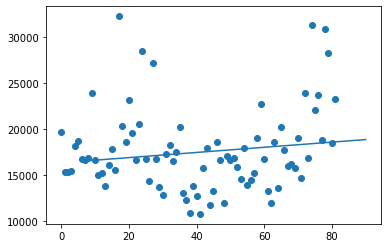

In [723]:
results.fittedvalues.plot()
plt.scatter(range(len(results.fittedvalues)),Households3.Total_consumption)

In [ ]:
Допустим параметр Фриша=-2

Доупустим, суммарная минимальная норма потребления = прожитончому минимуму региона.

Тогда мы можем построить SUR. 

### Модель с ценами